# Compare the multipoles of runs 

### In this notebook we compare the predicted galaxy power spectrum multipoles to BOSS-DR12 data.

## Import required modules

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy import Class
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
from scipy.integrate import odeint
import math
import pickle
from numpy.fft import fft, ifft , rfft, irfft , fftfreq
from numpy import exp, log, log10, cos, sin, pi, cosh, sinh , sqrt
from scipy.special import gamma
from scipy import interpolate
from scipy.integrate import quad
import scipy.integrate as integrate
from scipy import special

%matplotlib inline

matplotlib.rcParams['axes.linewidth'] = 10
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['axes.labelsize'] = 75
matplotlib.rcParams['xtick.labelsize'] = 65 
matplotlib.rcParams['ytick.labelsize'] = 65
matplotlib.rcParams['legend.fontsize'] = 60
matplotlib.rcParams['axes.labelpad'] = 100

# 1. Download the z=0.61 and z=0.38 BOSS multipole data and errors taken from https://github.com/Michalychforever/lss_montepython/tree/master/data/ngc_z3

In [2]:
#Load multipole data 

dat_kz3, p0kz3, p2kz3, unknown = np.loadtxt('ngc_z3/pk.dat', unpack=True)

covmatz3 = np.loadtxt('ngc_z3/covmat.dat')

sigmasz3 = np.sqrt(covmatz3.diagonal())

dat_kz1, p0kz1, p2kz1, unknown = np.loadtxt('ngc_z1/pk.dat', unpack=True)

covmatz1 = np.loadtxt('ngc_z1/covmat.dat')

sigmasz1 = np.sqrt(covmatz1.diagonal())


dat_kz3sc, p0kz3sc, p2kz3sc, unknown = np.loadtxt('sgc_z3/pk.dat', unpack=True)

covmatz3sc = np.loadtxt('ngc_z3/covmat.dat')

sigmasz3sc = np.sqrt(covmatz3.diagonal())

dat_kz1sc, p0kz1sc, p2kz1sc, unknown = np.loadtxt('sgc_z1/pk.dat', unpack=True)

covmatz1sc = np.loadtxt('ngc_z1/covmat.dat')

sigmasz1sc = np.sqrt(covmatz1.diagonal())


## get the param dictionaries from the bestfit files 

In [3]:
fn_006 = '../bestfit/mnu_006.bestfit'
fn_009 = '../bestfit/mnu_009.bestfit'
fn_012 = '../bestfit/mnu_012.bestfit'
fn_015 = '../bestfit/mnu_015.bestfit'
fn_018 = '../bestfit/mnu_018.bestfit'
fn_024 = '../bestfit/mnu_024.bestfit'
fn_03 = '../bestfit/mnu_03.bestfit'
fn_lcdm = '../bestfit/LCDM.bestfit'

In [4]:
fns = [fn_006,fn_009,fn_012,fn_015,fn_018,fn_024,fn_03]
mnus= [6,9,12,15,18,24,30]
bfs_dict={}

In [5]:
i=0
for fn in fns: 
    with open(fn) as f:
        bfs_dict[f'{mnus[i]}'] = {}
        for line in f: 
            if line.split()[0] == '#':
                names = [line.split()[k].replace(',', '') for k in range(1,65)]
            else: 
                vals = line.split()
                
        for j in range(len(vals)):
            bfs_dict[f'{mnus[i]}'][names[j]] = vals[j]

    i+=1

In [6]:
#save the lcdm data in a dictionary 

with open(fn_lcdm) as f:
    bfs_dict['lcdm'] = {}
    for line in f: 
        if line.split()[0] == '#':
            names = [line.split()[k].replace(',', '') for k in range(1,62)]
        else: 
            vals = line.split()

    for j in range(len(vals)):
        bfs_dict['lcdm'][names[j]] = vals[j]

In [7]:
mnu_006_dict= bfs_dict['6']
mnu_012_dict= bfs_dict['12']
mnu_018_dict= bfs_dict['18']
mnu_024_dict= bfs_dict['24']
mnu_03_dict= bfs_dict['30']
mnu_015_dict= bfs_dict['15']
mnu_009_dict= bfs_dict['9']
lcdm_dict = bfs_dict['lcdm']

# 2. Set the parameter values for fiducial LCDM, fiducial EDE and the fixed $m_\nu$ runs 


### Set the fiducial EDE settings as per Hill et al paper VI: best fit model to non-LSS data (CMB, SH0ES and distance data) note that now we have fixed $\theta_s$ following setting the bestfit $H_0$ value and finding the corresponding value for $\theta_s$ from CLASS shooting algorithm. Paramters from table 1 in https://arxiv.org/pdf/1908.06995.pdf

In [8]:
z3 = 0.61 #compute non-linear corrections at the same redshift as for the NGC z3 likelihood!  
z1 = 0.38


In [9]:
#BEST FIT PARAMS FROM BF with LCDM model 
#TT,TE,EE +lowE -> switch to this + BAO 
LCDM_settings = {'output':'tCl pCl lCl mPk', 
                 '100*theta_s': lcdm_dict['100*theta_s'],
                 'ln10^{10}A_s': lcdm_dict['ln10^{10}A_s'],
                 'n_s': lcdm_dict['n_s'],
                 'omega_b':  float(lcdm_dict['omega_b']),
                 'omega_cdm': lcdm_dict['omega_cdm'],
                 'tau_reio': lcdm_dict['tau_reio'],
                 'l_max_scalars':3508,
                 'non linear':'HMcode',
                 'P_k_max_h/Mpc':30,
                 'Omega_Lambda':0,                      
                 'Omega_fld':0,                         
                 'Omega_scf': -1,                        #scf
                 'scf_parameters':'1, 1, 1, 1, 1, 0.0', #scf
                 'scf_tuning_index':3,                  #scf
                 'attractor_ic_scf':'no',               #scf
                 'n_scf':3,                             #scf
                 'CC_scf':1,                            #scf
                 'f_scf': np.power(10,26.59913),        #scf                              
                 'm_scf': 0,                            #scf: this guarantees fEDE is 0 (otherwise hard to force)
                 'thetai_scf': 2.83,        
                 'z_max_pk':2.,
                 'z_pk':'0.38,0.61'}

In [10]:
LCDM = Class()
LCDM.set(LCDM_settings)

#for computing non-linear MPS using 1-loop PT and IR resummation 
LCDM.set({'non linear':'PT',
        'IR resummation':'Yes',
        'Bias tracers':'Yes',
        'cb':'Yes',
        'RSD':'Yes',
        'AP':'Yes',
        'Omfid':'0.31'
       })


LCDM.compute()

In [11]:
EDE_fiducial_params= {'H0': 72.19,
         'log10z_c': 3.562,
         'thetai_scf': 2.83,
         'ln10^{10}A_s': np.log(22.15),
         'n_s': 0.9889,
         'omega_b': 0.0253,
         'omega_cdm': 0.12999,
         'tau_reio': 0.0511,
         'non linear':'HMCODE',
         'N_ncdm':1,
         'm_ncdm': 0.06,
         'N_ur':2.0328, 
         'Omega_Lambda':0.0, #set to zero as included in potential function! 
         'Omega_fld':0, 
         'Omega_scf':-1, 
         'n_scf':3, #n-value for potential 
         'CC_scf':1, 
         'scf_parameters':'1, 1, 1, 1, 1, 0.0', 
         'scf_tuning_index':3, 
         'attractor_ic_scf':'no', 
         'output':'tCl pCl lCl mPk', 
         'lensing':'yes', 
         'l_max_scalars':3508, 
         'P_k_max_h/Mpc':30,
         'z_max_pk':2.,
         'fEDE': 0.122, 
          'z_pk':'0.38,0.61'}


EDE_pp_bf_params= {'100*theta_s': mnu_006_dict['100*theta_s'],
         'log10z_c': mnu_006_dict['log10z_c'],
         'thetai_scf': mnu_006_dict['thetai_scf'],
         'ln10^{10}A_s': mnu_006_dict['ln10^{10}A_s'],
         'n_s': mnu_006_dict['n_s'],
         'omega_b':  float(mnu_006_dict['omega_b']),
         'omega_cdm': mnu_006_dict['omega_cdm'],
         'tau_reio': mnu_006_dict['tau_reio'],
         'fEDE': mnu_006_dict['fEDE'],
         'N_ncdm':1,
         'm_ncdm': 0.06,
         'N_ur':2.0328, 
         'Omega_Lambda':0.0, #set to zero as included in potential function! 
         'Omega_fld':0, 
         'Omega_scf':-1, 
         'n_scf':3, #n-value for potential 
         'CC_scf':1, 
         'scf_parameters':'1, 1, 1, 1, 1, 0.0', 
         'scf_tuning_index':3, 
         'attractor_ic_scf':'no', 
         'output':'tCl pCl lCl mPk', 
         'lensing':'yes', 
         'l_max_scalars':3508, 
         'P_k_max_h/Mpc':30,
         'z_max_pk':2., 
         'z_pk':'0.38,0.61'}


EDE_mnu_03_pp_bf_params= {'100*theta_s': mnu_03_dict['100*theta_s'],
         'log10z_c': mnu_03_dict['log10z_c'],
         'thetai_scf': mnu_03_dict['thetai_scf'],
         'ln10^{10}A_s': mnu_03_dict['ln10^{10}A_s'],
         'n_s': mnu_03_dict['n_s'],
         'omega_b':  float(mnu_03_dict['omega_b']),
         'omega_cdm': mnu_03_dict['omega_cdm'],
         'tau_reio': mnu_03_dict['tau_reio'],
         'fEDE': mnu_03_dict['fEDE'],
         'non linear':'HMCODE',
         'N_ncdm':1,
         'm_ncdm': 0.3,
         'N_ur':2.0328, 
         'Omega_Lambda':0.0, #set to zero as included in potential function! 
         'Omega_fld':0, 
         'Omega_scf':-1, 
         'n_scf':3, #n-value for potential 
         'CC_scf':1, 
         'scf_parameters':'1, 1, 1, 1, 1, 0.0', 
         'scf_tuning_index':3, 
         'attractor_ic_scf':'no', 
         'output':'tCl pCl lCl mPk', 
         'lensing':'yes', 
         'l_max_scalars':3508, 
         'P_k_max_h/Mpc':30,
         'z_max_pk':2., 
         'z_pk':'0.38,0.61'} 


EDE_mnu_018_pp_bf_params= {'100*theta_s': mnu_018_dict['100*theta_s'],
         'log10z_c': mnu_018_dict['log10z_c'],
         'thetai_scf': mnu_018_dict['thetai_scf'],
         'ln10^{10}A_s': mnu_018_dict['ln10^{10}A_s'],
         'n_s': mnu_018_dict['n_s'],
         'omega_b':  float(mnu_018_dict['omega_b']),
         'omega_cdm': mnu_018_dict['omega_cdm'],
         'tau_reio': mnu_018_dict['tau_reio'],
         'fEDE': mnu_018_dict['fEDE'],
         'non linear':'HMCODE',
         'N_ncdm':1,
         'm_ncdm': 0.18,
         'N_ur':2.0328, 
         'Omega_Lambda':0.0, #set to zero as included in potential function! 
         'Omega_fld':0, 
         'Omega_scf':-1, 
         'n_scf':3, #n-value for potential 
         'CC_scf':1, 
         'scf_parameters':'1, 1, 1, 1, 1, 0.0', 
         'scf_tuning_index':3, 
         'attractor_ic_scf':'no', 
         'output':'tCl pCl lCl mPk', 
         'lensing':'yes', 
         'l_max_scalars':3508, 
         'P_k_max_h/Mpc':30,
         'z_max_pk':2., 
         'z_pk':'0.38,0.61'} 


EDE_mnu_024_pp_bf_params= {'100*theta_s': mnu_024_dict['100*theta_s'],
         'log10z_c': mnu_024_dict['log10z_c'],
         'thetai_scf': mnu_024_dict['thetai_scf'],
         'ln10^{10}A_s': mnu_024_dict['ln10^{10}A_s'],
         'n_s': mnu_024_dict['n_s'],
         'omega_b':  float(mnu_024_dict['omega_b']),
         'omega_cdm': mnu_024_dict['omega_cdm'],
         'tau_reio': mnu_024_dict['tau_reio'],
         'fEDE': mnu_024_dict['fEDE'],
         'non linear':'HMCODE',      
         'N_ncdm':1,
         'm_ncdm': 0.24,
         'N_ur':2.0328, 
         'Omega_Lambda':0.0, #set to zero as included in potential function! 
         'Omega_fld':0, 
         'Omega_scf':-1, 
         'n_scf':3, #n-value for potential 
         'CC_scf':1, 
         'scf_parameters':'1, 1, 1, 1, 1, 0.0', 
         'scf_tuning_index':3, 
         'attractor_ic_scf':'no', 
         'output':'tCl pCl lCl mPk', 
         'lensing':'yes', 
         'l_max_scalars':3508, 
         'P_k_max_h/Mpc':30,
         'z_max_pk':2., 
         'z_pk':'0.38,0.61'} 

EDE_mnu_015_pp_bf_params= {'100*theta_s': mnu_015_dict['100*theta_s'],
         'log10z_c': mnu_015_dict['log10z_c'],
         'thetai_scf': mnu_015_dict['thetai_scf'],
         'ln10^{10}A_s': mnu_015_dict['ln10^{10}A_s'],
         'n_s': mnu_015_dict['n_s'],
         'omega_b':  float(mnu_015_dict['omega_b']),
         'omega_cdm': mnu_015_dict['omega_cdm'],
         'tau_reio': mnu_015_dict['tau_reio'],
         'fEDE': mnu_015_dict['fEDE'],
         'non linear':'HMCODE',      
         'N_ncdm':1,
         'm_ncdm': 0.15,
         'N_ur':2.0328, 
         'Omega_Lambda':0.0, #set to zero as included in potential function! 
         'Omega_fld':0, 
         'Omega_scf':-1, 
         'n_scf':3, #n-value for potential 
         'CC_scf':1, 
         'scf_parameters':'1, 1, 1, 1, 1, 0.0', 
         'scf_tuning_index':3, 
         'attractor_ic_scf':'no', 
         'output':'tCl pCl lCl mPk', 
         'lensing':'yes', 
         'l_max_scalars':3508, 
         'P_k_max_h/Mpc':30,
         'z_max_pk':2., 
         'z_pk':'0.38,0.61'} 

EDE_mnu_009_pp_bf_params= {'100*theta_s': mnu_009_dict['100*theta_s'],
         'log10z_c': mnu_009_dict['log10z_c'],
         'thetai_scf': mnu_009_dict['thetai_scf'],
         'ln10^{10}A_s': mnu_009_dict['ln10^{10}A_s'],
         'n_s': mnu_009_dict['n_s'],
         'omega_b':  float(mnu_009_dict['omega_b']),
         'omega_cdm': mnu_009_dict['omega_cdm'],
         'tau_reio': mnu_009_dict['tau_reio'],
         'fEDE': mnu_009_dict['fEDE'],
         'non linear':'HMCODE',      
         'N_ncdm':1,
         'm_ncdm': 0.09,
         'N_ur':2.0328, 
         'Omega_Lambda':0.0, #set to zero as included in potential function! 
         'Omega_fld':0, 
         'Omega_scf':-1, 
         'n_scf':3, #n-value for potential 
         'CC_scf':1, 
         'scf_parameters':'1, 1, 1, 1, 1, 0.0', 
         'scf_tuning_index':3, 
         'attractor_ic_scf':'no', 
         'output':'tCl pCl lCl mPk', 
         'lensing':'yes', 
         'l_max_scalars':3508, 
         'P_k_max_h/Mpc':30,
         'z_max_pk':2., 
         'z_pk':'0.38,0.61'} 

EDE_mnu_012_pp_bf_params= {'100*theta_s': mnu_012_dict['100*theta_s'],
         'log10z_c': mnu_012_dict['log10z_c'],
         'thetai_scf': mnu_012_dict['thetai_scf'],
         'ln10^{10}A_s': mnu_012_dict['ln10^{10}A_s'],
         'n_s': mnu_012_dict['n_s'],
         'omega_b':  float(mnu_012_dict['omega_b']),
         'omega_cdm': mnu_012_dict['omega_cdm'],
         'tau_reio': mnu_012_dict['tau_reio'],
         'fEDE': mnu_012_dict['fEDE'],
         'non linear':'HMCODE',      
         'N_ncdm':1,
         'm_ncdm': 0.12,
         'N_ur':2.0328, 
         'Omega_Lambda':0.0, #set to zero as included in potential function! 
         'Omega_fld':0, 
         'Omega_scf':-1, 
         'n_scf':3, #n-value for potential 
         'CC_scf':1, 
         'scf_parameters':'1, 1, 1, 1, 1, 0.0', 
         'scf_tuning_index':3, 
         'attractor_ic_scf':'no', 
         'output':'tCl pCl lCl mPk', 
         'lensing':'yes', 
         'l_max_scalars':3508, 
         'P_k_max_h/Mpc':30,
         'z_max_pk':2., 
         'z_pk':'0.38,0.61'} 

In [12]:
EDE_pp = Class()
EDE_pp.set(EDE_pp_bf_params)

#for computing non-linear MPS using 1-loop PT and IR resummation 
EDE_pp.set({'non linear':'SPT',
        'k_pivot':'0.05',
        'IR resummation':'Yes',
        'Bias tracers':'Yes',
        'cb':'Yes',
        'RSD':'Yes',
        'AP':'Yes',
        'Omfid':'0.31'
       })

EDE_pp.compute()

In [13]:
EDE_fiducial = Class()
EDE_fiducial.set(EDE_fiducial_params)


#for computing non-linear MPS using 1-loop PT and IR resummation 
EDE_fiducial.set({'non linear':'SPT',
        'k_pivot':'0.05',
        'IR resummation':'Yes',
        'Bias tracers':'Yes',
        'cb':'Yes',
        'RSD':'Yes',
        'AP':'Yes',
        'Omfid':'0.31'
       })


EDE_fiducial.compute()

In [14]:
EDE_mnu03 = Class()
EDE_mnu03.set(EDE_mnu_03_pp_bf_params)

#for computing non-linear MPS using 1-loop PT and IR resummation 
EDE_mnu03.set({'non linear':'SPT',
        'k_pivot':'0.05',
        'IR resummation':'Yes',
        'Bias tracers':'Yes',
        'cb':'Yes',
        'RSD':'Yes',
        'AP':'Yes',
        'Omfid':'0.31'
       })

EDE_mnu03.compute()

In [15]:
#for computing non-linear MPS using 1-loop PT and IR resummation 
EDE_mnu018 = Class()
EDE_mnu018.set(EDE_mnu_018_pp_bf_params)
EDE_mnu018.set({'non linear':'SPT',
        'k_pivot':'0.05',
        'IR resummation':'Yes',
        'Bias tracers':'Yes',
        'cb':'Yes',
        'RSD':'Yes',
        'AP':'Yes',
        'Omfid':'0.31'
       })

EDE_mnu018.compute()

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


In [16]:
#for computing non-linear MPS using 1-loop PT and IR resummation 
EDE_mnu024 = Class()
EDE_mnu024.set(EDE_mnu_024_pp_bf_params)
EDE_mnu024.set({'non linear':'SPT',
        'k_pivot':'0.05',
        'IR resummation':'Yes',
        'Bias tracers':'Yes',
        'cb':'Yes',
        'RSD':'Yes',
        'AP':'Yes',
        'Omfid':'0.31'
       })

EDE_mnu024.compute()

In [17]:
#for computing non-linear MPS using 1-loop PT and IR resummation 
EDE_mnu012 = Class()
EDE_mnu012.set(EDE_mnu_012_pp_bf_params)
EDE_mnu012.set({'non linear':'SPT',
        'k_pivot':'0.05',
        'IR resummation':'Yes',
        'Bias tracers':'Yes',
        'cb':'Yes',
        'RSD':'Yes',
        'AP':'Yes',
        'Omfid':'0.31'
       })

EDE_mnu012.compute()

In [18]:
#for computing non-linear MPS using 1-loop PT and IR resummation 
EDE_mnu015 = Class()
EDE_mnu015.set(EDE_mnu_015_pp_bf_params)
EDE_mnu015.set({'non linear':'SPT',
        'k_pivot':'0.05',
        'IR resummation':'Yes',
        'Bias tracers':'Yes',
        'cb':'Yes',
        'RSD':'Yes',
        'AP':'Yes',
        'Omfid':'0.31'
       })

EDE_mnu015.compute()

In [19]:
#for computing non-linear MPS using 1-loop PT and IR resummation 
EDE_mnu009 = Class()
EDE_mnu009.set(EDE_mnu_009_pp_bf_params)
EDE_mnu009.set({'non linear':'SPT',
        'k_pivot':'0.05',
        'IR resummation':'Yes',
        'Bias tracers':'Yes',
        'cb':'Yes',
        'RSD':'Yes',
        'AP':'Yes',
        'Omfid':'0.31'
       })

EDE_mnu009.compute()

In [20]:
b1 = 1.819736572651593
cs = 1. # in units [Mpc/h]^2
b2 = -3.5142879639974764
bG2 = 0.6942619836144907
bGamma3 = 0.
Pshot = 7431.955177445927 # in units [Mpc/h]^3
cs0 = -10.711564425954903 # in units [Mpc/h]^2
cs2 = -46.19171787820874 # in units [Mpc/h]^2
cs4 = -5. # in units [Mpc/h]^2
b4 = 266.68840332551514 # in units [Mpc/h]^4

## Using CLASS-PT to find the predicted redshift-space monopole/quadropole

In [21]:
# THESE NEED TO BE UPDATED NOW PLEASE! 
path2window = '/home/ar901/rds/hpc-work/montepython_public/data/ngc_z3/window.dat'
path2measurements = '/home/ar901/rds/hpc-work/montepython_public/data/ngc_z3/pk.dat'
ksize = 48

In [22]:
def get_theory_pk(cosmo, z, ksize, experiment, dic):
    '''
    Get the theory prediction for the multipoles. This function mirrors exactly the likelihood '.init' in MontePython
    
    Parameters: 
    cosmo: An input CLASS instance 
    z: redshift of survey (0.38 or 0.61)
    ksize: the number of data points in the survey (always 48) 
    experiment: 'sgc' or 'ngc' data chunk
    dic: input bestfit parameter dictionary
    
    Returns: total data vector, k values, l=0 multipole, l=2 multipole
    '''
    
    
    path2window = './' + experiment + '/window.dat'
    path2measurements = './' + experiment + '/pk.dat'

    if experiment == 'ngc_z3':
        
        i_s=repr(1)
        
    
    elif experiment == 'sgc_z3':
        i_s=repr(2)
        
    
    elif experiment == 'ngc_z1':
        i_s=repr(3)
        
    
    elif experiment == 'sgc_z1':
        
        i_s=repr(4)
        
    else:
        print('error!')
        
    
    
    b1 =  float(dic['b^{('+i_s+')}_1'])
    cs = 1. # in units [Mpc/h]^2
    b2 = float(dic['b^{('+i_s+')}_2'])
    bG2 = float(dic['b^{('+i_s+')}_{G_2}'])
    bGamma3 = 0.
    Pshot = float(dic['P^{('+i_s+')}_{shot}'])
    css0 = float(dic['c^{('+i_s+')}_{0}'])
    css2 = float(dic['c^{('+i_s+')}_{2}'])
    b4 = float(dic['b^{('+i_s+')}_4'])
    
    #This function takes a class output and calculates the predicted theory p(k) for the redshoft space multipoles
    
    k = np.zeros(ksize,'float64') #measured k values 
    datafile = open(path2measurements, 'r')
    for i in range(ksize):
        line = datafile.readline()
        while line.find('#') != -1:
            line = datafile.readline()
        k[i] = float(line.split()[0])
    
    h = cosmo.h()
    norm = 1.
    
    bGamma3 = 0.
    a2 = 0.
    Nmax = 128
    b = -1.1001
    kmax = 100.
    k0 = 1.e-4

    rtab = np.zeros(Nmax)
    rmin = 0.01
    rmax = 1000.

    Delta = log(kmax/k0) / (Nmax - 1)
    
    Delta_r = log(rmax/rmin) / (Nmax - 1)

    Pdiscrin0 = np.zeros(Nmax);
    Pdiscrin2 = np.zeros(Nmax);
    jsNm = np.arange(-Nmax/2,Nmax/2+1,1)
    etam = b + 2*1j*pi*(jsNm)/Nmax/Delta
    kbins3 = np.zeros(Nmax);

    z = z
    fz = cosmo.scale_independent_growth_factor_f(z)
    
    
    for i in range(Nmax):

        kbins3[i] = k0 * exp(Delta * i)
        kinloop1 = kbins3[i] * h
        rtab[i] = rmin * exp(Delta_r * i)
        
        theory2 = (norm**2.*cosmo.pk(kinloop1, z)[18] +norm**4.*(cosmo.pk(kinloop1, z)[24])+ norm**1.*b1*cosmo.pk(kinloop1, z)[19] +norm**3.*b1*(cosmo.pk(kinloop1, z)[25]) + b1**2.*norm**2.*cosmo.pk(kinloop1, z)[26] +b1*b2*norm**2.*cosmo.pk(kinloop1, z)[34]+ b2*norm**3.*cosmo.pk(kinloop1, z)[35] + b1*bG2*norm**2.*cosmo.pk(kinloop1, z)[36]+ bG2*norm**3.*cosmo.pk(kinloop1, z)[37]  + 2.*(css2 + 0.*b4*kinloop1**2.)*norm**2.*cosmo.pk(kinloop1, z)[12]/h**2. + (2.*bG2+0.8*bGamma3)*norm**3.*cosmo.pk(kinloop1, z)[9])*h**3. + fz**2.*b4*kbins3[i]**2.*((norm**2.*fz**2.*70. + 165.*fz*b1*norm+99.*b1**2.)*4./693.)*(35./8.)*cosmo.pk(kinloop1, z)[13]*h 
        theory0 = (norm**2.*cosmo.pk(kinloop1, z)[15] +norm**4.*(cosmo.pk(kinloop1, z)[21])+ norm**1.*b1*cosmo.pk(kinloop1, z)[16] +norm**3.*b1*(cosmo.pk(kinloop1, z)[22]) + norm**0.*b1**2.*cosmo.pk(kinloop1, z)[17] +norm**2.*b1**2.*cosmo.pk(kinloop1, z)[23] + 0.25*norm**2.*b2**2.*cosmo.pk(kinloop1, z)[1] +b1*b2*norm**2.*cosmo.pk(kinloop1, z)[30]+ b2*norm**3.*cosmo.pk(kinloop1, z)[31] + b1*bG2*norm**2.*cosmo.pk(kinloop1, z)[32]+ bG2*norm**3.*cosmo.pk(kinloop1, z)[33] + b2*bG2*norm**2.*cosmo.pk(kinloop1, z)[4]+ bG2**2.*norm**2.*cosmo.pk(kinloop1, z)[5] + 2.*css0*norm**2.*cosmo.pk(kinloop1, z)[11]/h**2. + (2.*bG2+0.8*bGamma3)*norm**2.*(b1*cosmo.pk(kinloop1, z)[7]+norm*cosmo.pk(kinloop1, z)[8]))*h**3.+Pshot + fz**2.*b4*kbins3[i]**2.*(norm**2.*fz**2./9. + 2.*fz*b1*norm/7. + b1**2./5)*(35./8.)*cosmo.pk(kinloop1,z)[13]*h           
        
        
        Pdiscrin0[i] = theory0 * exp(-1.*(kinloop1/2.)**4.-1.*b*i*Delta)
        Pdiscrin2[i] = theory2 * exp(-1.*(kinloop1/2.)**4.-1.*b*i*Delta)


    cm0 = np.fft.fft(Pdiscrin0)/ Nmax
    cm2 = np.fft.fft(Pdiscrin2)/ Nmax
    

    cmsym0 = np.zeros(Nmax+1,dtype=np.complex_)
    cmsym2 = np.zeros(Nmax+1,dtype=np.complex_)

    for i in range(Nmax+1):
        if (i+2 - Nmax/2) < 1:

            cmsym0[i] =  k0**(-etam[i])*np.conjugate(cm0[int(-i + Nmax/2)])
            cmsym2[i] =  k0**(-etam[i])*np.conjugate(cm2[int(-i + Nmax/2)])
        else:
            cmsym0[i] = k0**(-etam[i])* cm0[int(i - Nmax/2)]
            cmsym2[i] = k0**(-etam[i])* cm2[int(i - Nmax/2)]

    cmsym0[-1] = cmsym0[-1] / 2
    cmsym0[0] = cmsym0[0] / 2
    cmsym2[-1] = cmsym2[-1] / 2
    cmsym2[0] = cmsym2[0] / 2

    def J0(r,nu):
        return -1.*np.sin(pi*nu/2.)*r**(-3.-1.*nu)*special.gamma(2+nu)/(2.*pi**2.)
    def J2(r,nu):
        return r**(-3.-1.*nu)*(3.+nu)*special.gamma(2.+nu)*np.sin(pi*nu/2.)/(nu*2.*pi**2.)
    xi0 = np.zeros(Nmax)
    xi2 = np.zeros(Nmax)

    for i in range(Nmax):
        for j in range(Nmax + 1):
            xi0[i] = xi0[i] + np.real(cmsym0[j]*J0(rtab[i],etam[j]))
            xi2[i] = xi2[i] + np.real(cmsym2[j]*J2(rtab[i],etam[j]))

    W0 = np.zeros(Nmax)
    W2 = np.zeros(Nmax)
    W4 = np.zeros(Nmax)
    datafile = open(path2window, 'r')
    for i in range(Nmax):
        line = datafile.readline()
        while line.find('#') != -1:
            line = datafile.readline()
        W0[i] = float(line.split()[0])
        W2[i] = float(line.split()[1])
        W4[i] = float(line.split()[2]) 

    bR = -2.001
    Xidiscrin0 = np.zeros(Nmax);
    Xidiscrin2 = np.zeros(Nmax);
    etamR = bR + 2*1j*pi*(jsNm)/Nmax/Delta_r

    for i in range(Nmax):
        Xidiscrin0[i] = (xi0[i]*W0[i] + 0.2*xi2[i]*W2[i])* exp(-1.*bR*i*Delta_r)
        Xidiscrin2[i] = (xi0[i]*W2[i] + xi2[i]*(W0[i] + 2.*(W2[i]+W4[i])/7.))* exp(-1.*bR*i*Delta_r)

    cmr0 = np.fft.fft(Xidiscrin0)/ Nmax
    cmr2 = np.fft.fft(Xidiscrin2)/ Nmax

    cmsymr0 = np.zeros(Nmax+1,dtype=np.complex_)
    cmsymr2 = np.zeros(Nmax+1,dtype=np.complex_)

    for i in range(Nmax+1):
        if (i+2 - Nmax/2) < 1:
            cmsymr0[i] =  rmin**(-etamR[i])*np.conjugate(cmr0[int(-i + Nmax//2)])
            cmsymr2[i] =  rmin**(-etamR[i])*np.conjugate(cmr2[int(-i + Nmax//2)])
        else:
            cmsymr0[i] = rmin**(-etamR[i])* cmr0[int(i - Nmax//2)]
            cmsymr2[i] = rmin**(-etamR[i])* cmr2[int(i - Nmax//2)]

    cmsymr0[-1] = cmsymr0[-1] / 2
    cmsymr0[0] = cmsymr0[0] / 2
    cmsymr2[-1] = cmsymr2[-1] / 2
    cmsymr2[0] = cmsymr2[0] / 2

    def J0k(k,nu):
        return -1.*k**(-3.-1.*nu)*special.gamma(2+nu)*np.sin(pi*nu/2.)*(4.*pi)
    def J2k(k,nu):
        return k**(-3.-1.*nu)*(3.+nu)*special.gamma(2.+nu)*np.sin(pi*nu/2.)*4.*pi/nu

    P0t = np.zeros(Nmax)
    P2t = np.zeros(Nmax)

    for i in range(Nmax):
        for j in range(Nmax + 1):
            P0t[i] = P0t[i] + np.real(cmsymr0[j]*J0k(kbins3[i],etamR[j]))
            P2t[i] = P2t[i] + np.real(cmsymr2[j]*J2k(kbins3[i],etamR[j]))

    P0int = interpolate.InterpolatedUnivariateSpline(kbins3,P0t)
    P2int = interpolate.InterpolatedUnivariateSpline(kbins3,P2t)

    
    x1 = np.zeros(2*ksize)
    for i in range(ksize):
        x1[i] = P0int(k[i])
        x1[ksize + i] = P2int(k[i])
        
    
    return x1, k, P0int, P2int




In [23]:
##### NUISANCE PARAMETERS FOR FIDUCIAL MODEL #####
#Use these for the fiducial EDE model taked from fidcucial model parameters in MI notebook 

b1EDE = 1.7801562076765094
csEDE = 1. # in units [Mpc/h]^2
b2EDE = -3.3229633099327973
bG2EDE = 0.6643694833607848
bGamma3EDE = 0.
PshotEDE = 6699.631293444604 # in units [Mpc/h]^3
cs0EDE = -22.210780706934052 # in units [Mpc/h]^2
cs2EDE = -45.03173430337345 # in units [Mpc/h]^2
cs4EDE = -5 # in units [Mpc/h]^2
b4EDE = 251.77513281428483# in units [Mpc/h]^4


### Calculate the ngc and sgc z3 multipoles

In [24]:
pk_total_EDE_ppz3, kvalsz3, p0_EDE_ppz3, p2_EDE_ppz3 = get_theory_pk(EDE_pp, z3,ksize, 'ngc_z3', dic=mnu_006_dict)
pk_total_EDE_mnu012z3, kvalsz3,p0_EDE_mnu012z3,p2_EDE_mnu012z3 = get_theory_pk(EDE_mnu012, z3,ksize, 'ngc_z3', dic=mnu_012_dict)
pk_total_EDE_mnu018z3, kvalsz3,p0_EDE_mnu018z3,p2_EDE_mnu018z3 = get_theory_pk(EDE_mnu018, z3,ksize, 'ngc_z3', dic=mnu_018_dict)
pk_total_EDE_mnu024z3, kvalsz3,p0_EDE_mnu024z3,p2_EDE_mnu024z3 = get_theory_pk(EDE_mnu024, z3,ksize, 'ngc_z3',dic=mnu_024_dict)
pk_total_EDE_mnu015z3, kvalsz3,p0_EDE_mnu015z3,p2_EDE_mnu015z3 = get_theory_pk(EDE_mnu015, z3,ksize, 'ngc_z3', dic=mnu_015_dict)
pk_total_EDE_mnu009z3, kvalsz3,p0_EDE_mnu009z3,p2_EDE_mnu009z3 = get_theory_pk(EDE_mnu009, z3,ksize, 'ngc_z3', dic=mnu_009_dict)
pk_total_EDE_mnu03z3, kvalsz3,p0_EDE_mnu03z3,p2_EDE_mnu03z3 = get_theory_pk(EDE_mnu03, z3,ksize, 'ngc_z3', dic=mnu_03_dict)


In [25]:
pk_total_EDE_ppz3sc, kvalsz3sc, p0_EDE_ppz3sc, p2_EDE_ppz3sc = get_theory_pk(EDE_pp, z3,ksize, 'sgc_z3', dic=mnu_006_dict)
pk_total_EDE_mnu012z3sc, kvalsz3sc,p0_EDE_mnu012z3sc,p2_EDE_mnu012z3sc = get_theory_pk(EDE_mnu012, z3,ksize, 'sgc_z3', dic=mnu_012_dict)
pk_total_EDE_mnu018z3sc, kvalsz3sc,p0_EDE_mnu018z3sc,p2_EDE_mnu018z3sc = get_theory_pk(EDE_mnu018, z3,ksize, 'sgc_z3', dic=mnu_018_dict)
pk_total_EDE_mnu024z3sc, kvalsz3sc,p0_EDE_mnu024z3sc,p2_EDE_mnu024z3sc = get_theory_pk(EDE_mnu024, z3,ksize, 'sgc_z3',dic=mnu_024_dict)
pk_total_EDE_mnu03z3sc, kvalsz3sc,p0_EDE_mnu03z3sc,p2_EDE_mnu03z3sc = get_theory_pk(EDE_mnu03, z3,ksize, 'sgc_z3', dic=mnu_03_dict)
pk_total_EDE_mnu015z3sc, kvalsz3sc,p0_EDE_mnu015z3sc,p2_EDE_mnu015z3sc = get_theory_pk(EDE_mnu015, z3,ksize, 'sgc_z3',dic=mnu_015_dict)
pk_total_EDE_mnu009z3sc, kvalsz3sc,p0_EDE_mnu009z3sc,p2_EDE_mnu009z3sc = get_theory_pk(EDE_mnu009, z3,ksize, 'sgc_z3',dic=mnu_009_dict)


## Plot the data and residuals for ngc z3
Display the monopole and quadropole moments of the redshift-space galaxy power spectrum field 

### Compute the residuals against data

In [26]:
#################################################################################################
#----------------------------------------NGC----------------------------------------------------#

pk_g0_EDE_pp_ratioz3 = (pk_total_EDE_ppz3[0:48]-p0kz3)/(sigmasz3[0:48]) 
pk_g2_EDE_pp_ratioz3 = (pk_total_EDE_ppz3[48:]-p2kz3)/(sigmasz3[48:]) 

pk_g0_EDE_mnu012_ratioz3 = (pk_total_EDE_mnu012z3[0:48]-p0kz3)/(sigmasz3[0:48])  
pk_g2_EDE_mnu012_ratioz3 = (pk_total_EDE_mnu012z3[48:]-p2kz3)/(sigmasz3[48:])  

pk_g0_EDE_mnu018_ratioz3 = (pk_total_EDE_mnu018z3[0:48]-p0kz3)/(sigmasz3[0:48])  
pk_g2_EDE_mnu018_ratioz3 = (pk_total_EDE_mnu018z3[48:]-p2kz3)/(sigmasz3[48:])  

pk_g0_EDE_mnu024_ratioz3 = (pk_total_EDE_mnu024z3[0:48]-p0kz3)/(sigmasz3[0:48])  
pk_g2_EDE_mnu024_ratioz3 = (pk_total_EDE_mnu024z3[48:]-p2kz3)/(sigmasz3[48:]) 

pk_g0_EDE_mnu03_ratioz3 = (pk_total_EDE_mnu03z3[0:48]-p0kz3)/(sigmasz3[0:48]) 
pk_g2_EDE_mnu03_ratioz3 = (pk_total_EDE_mnu03z3[48:]-p2kz3)/(sigmasz3[48:])  

pk_g0_EDE_mnu009_ratioz3 = (pk_total_EDE_mnu009z3[0:48]-p0kz3)/(sigmasz3[0:48]) 
pk_g2_EDE_mnu009_ratioz3 = (pk_total_EDE_mnu009z3[48:]-p2kz3)/(sigmasz3[48:]) 

pk_g0_EDE_mnu015_ratioz3 = (pk_total_EDE_mnu015z3[0:48]-p0kz3)/(sigmasz3[0:48]) 
pk_g2_EDE_mnu015_ratioz3 = (pk_total_EDE_mnu015z3[48:]-p2kz3)/(sigmasz3[48:]) 


#################################################################################################
#----------------------------------------SGC----------------------------------------------------#


pk_g0_EDE_pp_ratioz3sc = (pk_total_EDE_ppz3sc[0:48]-p0kz3sc)/(sigmasz3sc[0:48]) 
pk_g2_EDE_pp_ratioz3sc = (pk_total_EDE_ppz3sc[48:]-p2kz3sc)/(sigmasz3sc[48:]) 

pk_g0_EDE_mnu012_ratioz3sc = (pk_total_EDE_mnu012z3sc[0:48]-p0kz3sc)/(sigmasz3sc[0:48])  
pk_g2_EDE_mnu012_ratioz3sc = (pk_total_EDE_mnu012z3sc[48:]-p2kz3sc)/(sigmasz3sc[48:])  

pk_g0_EDE_mnu018_ratioz3sc = (pk_total_EDE_mnu018z3sc[0:48]-p0kz3sc)/(sigmasz3sc[0:48])  
pk_g2_EDE_mnu018_ratioz3sc = (pk_total_EDE_mnu018z3sc[48:]-p2kz3sc)/(sigmasz3sc[48:])  

pk_g0_EDE_mnu024_ratioz3sc = (pk_total_EDE_mnu024z3sc[0:48]-p0kz3sc)/(sigmasz3sc[0:48])  
pk_g2_EDE_mnu024_ratioz3sc = (pk_total_EDE_mnu024z3sc[48:]-p2kz3sc)/(sigmasz3sc[48:]) 

pk_g0_EDE_mnu03_ratioz3sc = (pk_total_EDE_mnu03z3sc[0:48]-p0kz3sc)/(sigmasz3sc[0:48]) 
pk_g2_EDE_mnu03_ratioz3sc = (pk_total_EDE_mnu03z3sc[48:]-p2kz3sc)/(sigmasz3sc[48:])  

pk_g0_EDE_mnu009_ratioz3sc = (pk_total_EDE_mnu009z3sc[0:48]-p0kz3sc)/(sigmasz3sc[0:48]) 
pk_g2_EDE_mnu009_ratioz3sc = (pk_total_EDE_mnu009z3sc[48:]-p2kz3sc)/(sigmasz3sc[48:])  

pk_g0_EDE_mnu015_ratioz3sc = (pk_total_EDE_mnu015z3sc[0:48]-p0kz3sc)/(sigmasz3sc[0:48]) 
pk_g2_EDE_mnu015_ratioz3sc = (pk_total_EDE_mnu015z3sc[48:]-p2kz3sc)/(sigmasz3sc[48:]) 

### Plot residuals for ngcz3 and sgcz3

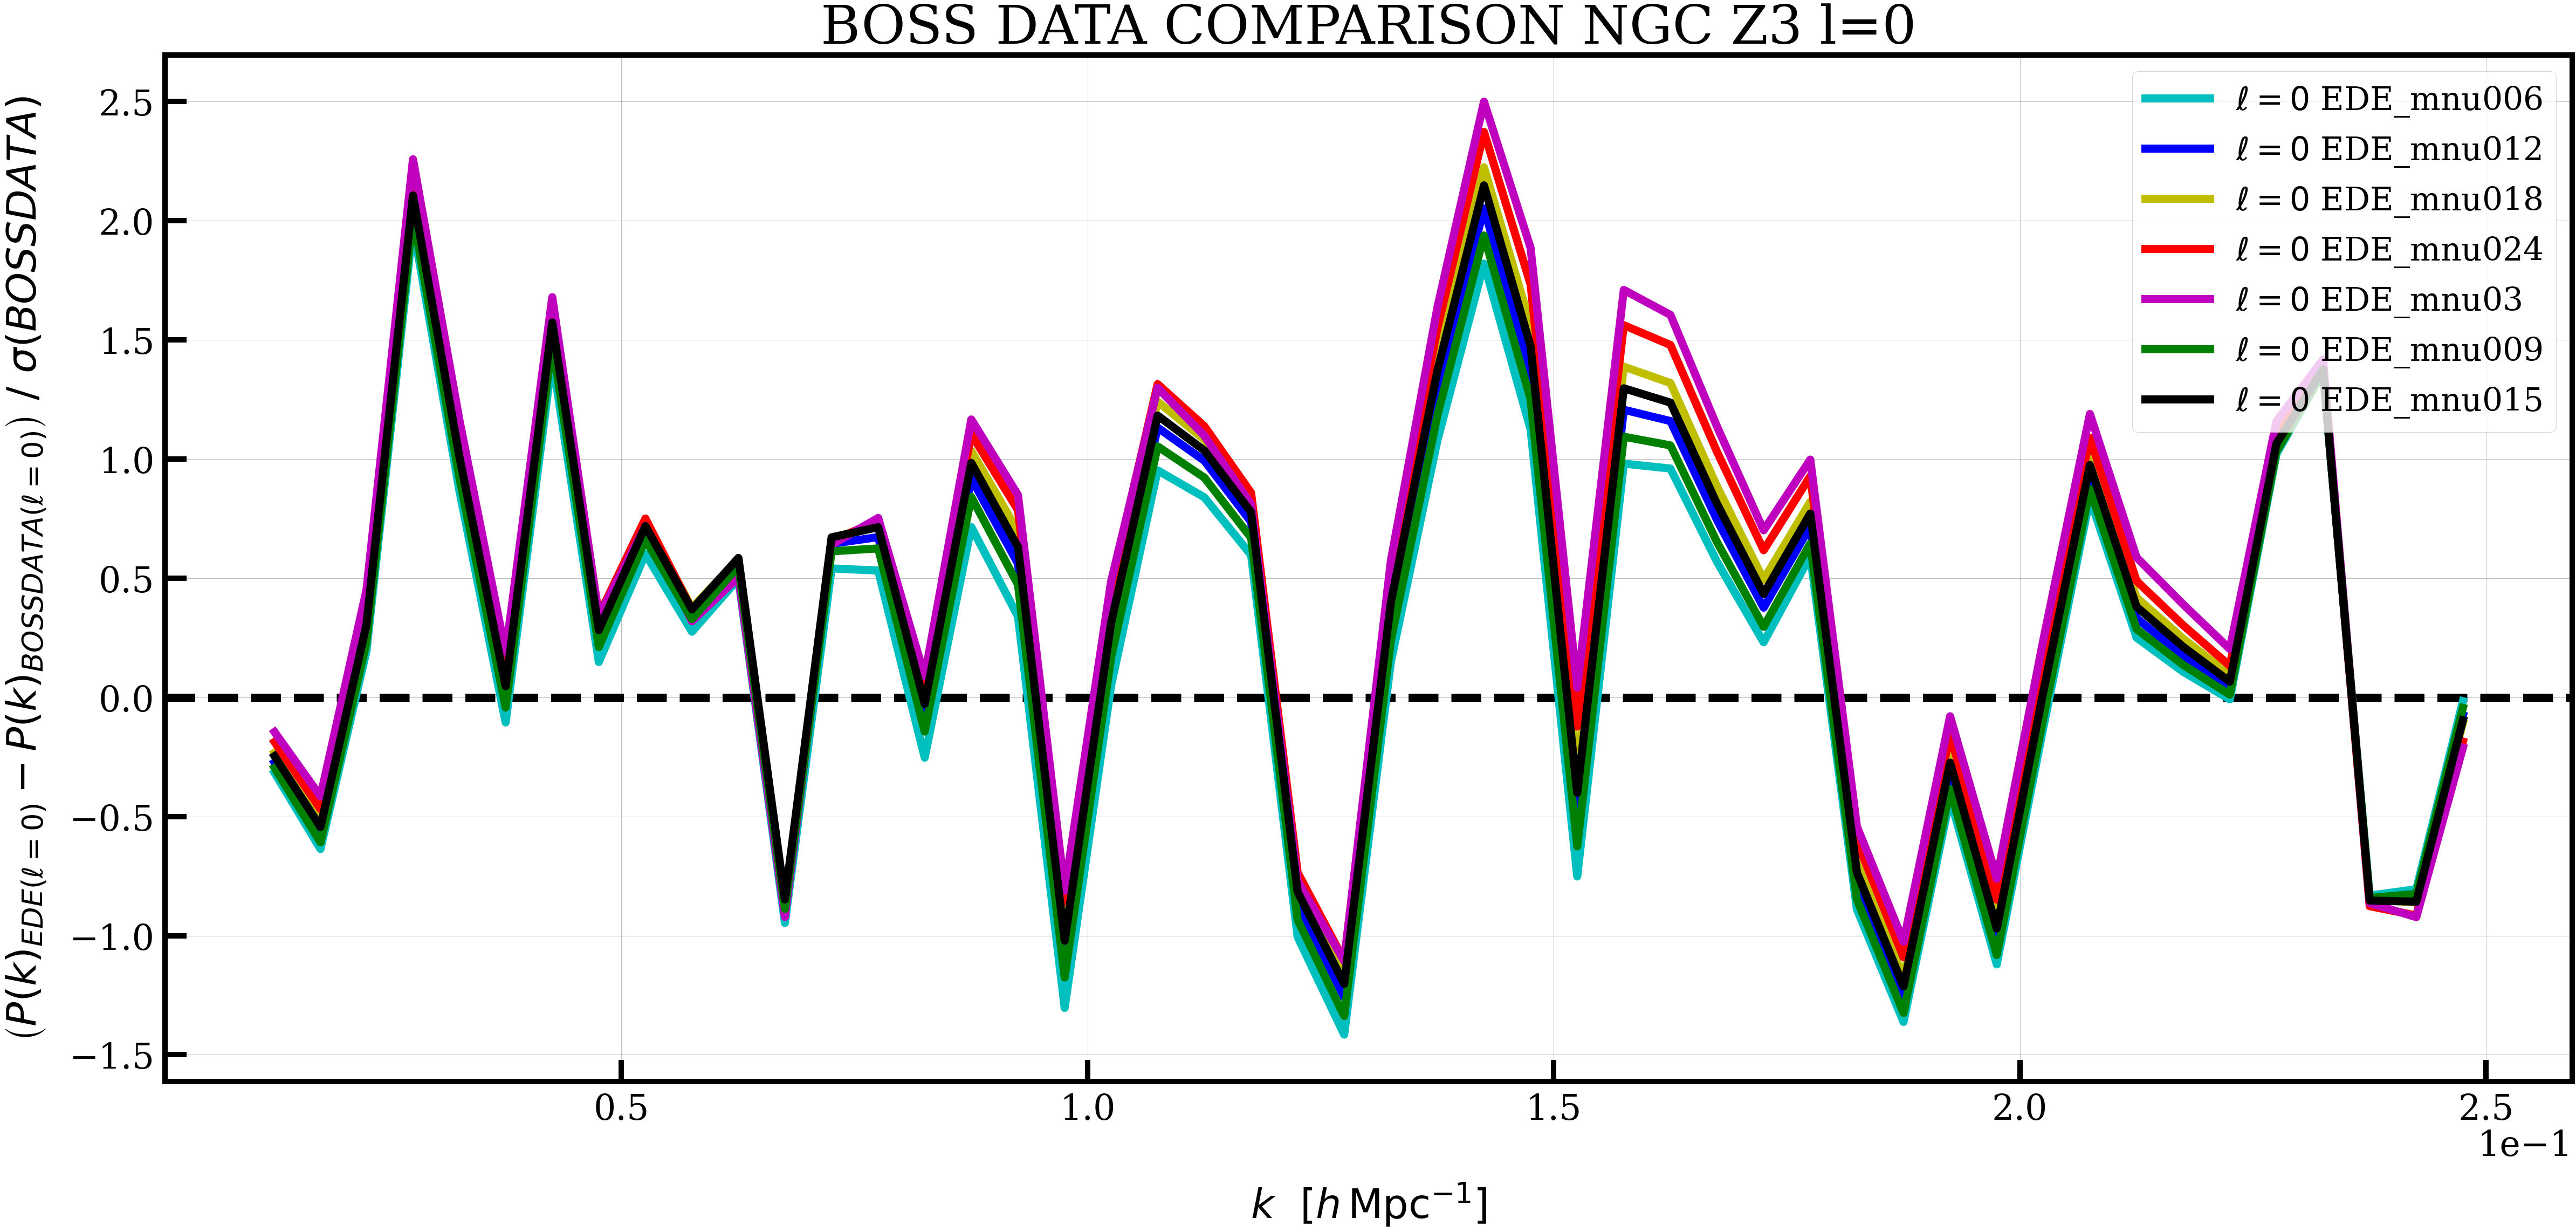

In [27]:
matplotlib.axis.YAxis.OFFSETTEXTPAD = 25
fig, ax2 = plt.subplots(figsize=(80,35))


ax2.grid()
ax2.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax2.axhline(0,c='k',lw=15,ls='--')

ax2.plot(kvalsz3,np.array(pk_g0_EDE_pp_ratioz3),color='c', markersize=100, lw=15, label=r'$\ell = 0$ EDE_mnu006')
ax2.plot(kvalsz3,np.array(pk_g0_EDE_mnu012_ratioz3),color='b', markersize=100,lw=15,  label=r'$\ell = 0$ EDE_mnu012')
ax2.plot(kvalsz3,np.array(pk_g0_EDE_mnu018_ratioz3), markersize=100, color='y',lw=15, label=r'$\ell = 0$ EDE_mnu018')
ax2.plot(kvalsz3,np.array(pk_g0_EDE_mnu024_ratioz3),color='r', markersize=100,lw=15, label=r'$\ell = 0$ EDE_mnu024')
ax2.plot(kvalsz3,np.array(pk_g0_EDE_mnu03_ratioz3),color='m', markersize=100,lw=15, label=r'$\ell = 0$ EDE_mnu03')
ax2.plot(kvalsz3,np.array(pk_g0_EDE_mnu009_ratioz3),color='g', markersize=100,lw=15, label=r'$\ell = 0$ EDE_mnu009')
ax2.plot(kvalsz3,np.array(pk_g0_EDE_mnu015_ratioz3),color='k', markersize=100,lw=15, label=r'$\ell = 0$ EDE_mnu015')

ax2.set_xlabel(r'$k$  $[h\, {\rm Mpc}^{-1}]$')
ax2.set_ylabel(r'$ \left( P(k)_{EDE (\ell =0)} - P(k)_{BOSS DATA (\ell =0)} \right) ~ \left/ ~ \sigma(BOSS DATA) \right.$',labelpad=40)#,fontsize=25)
ax2.tick_params(pad=20)
ax2.tick_params(which='major',axis='x', length=40, width=10, direction='in')
ax2.tick_params(which='minor',axis='x', length=25, width=5, direction='in')
ax2.tick_params(which='major',axis='y', length=40, width=10, direction='in')
ax2.tick_params(which='minor',axis='y', length=25, width=5, direction='in')


# ax2.errorbar(dat_kz3, np.zeros(48,), yerr = sigmasz3[0:48]/p0kz3, linestyle = 'none', color = 'k', marker = '+', markersize = '10', lw = 20)

ax2.legend(loc='best')


ax2.set_title('BOSS DATA COMPARISON NGC Z3 l=0', fontsize=100)

fig.savefig('multipoles_comparison_residual_l=0z3.pdf',bbox_inches='tight')

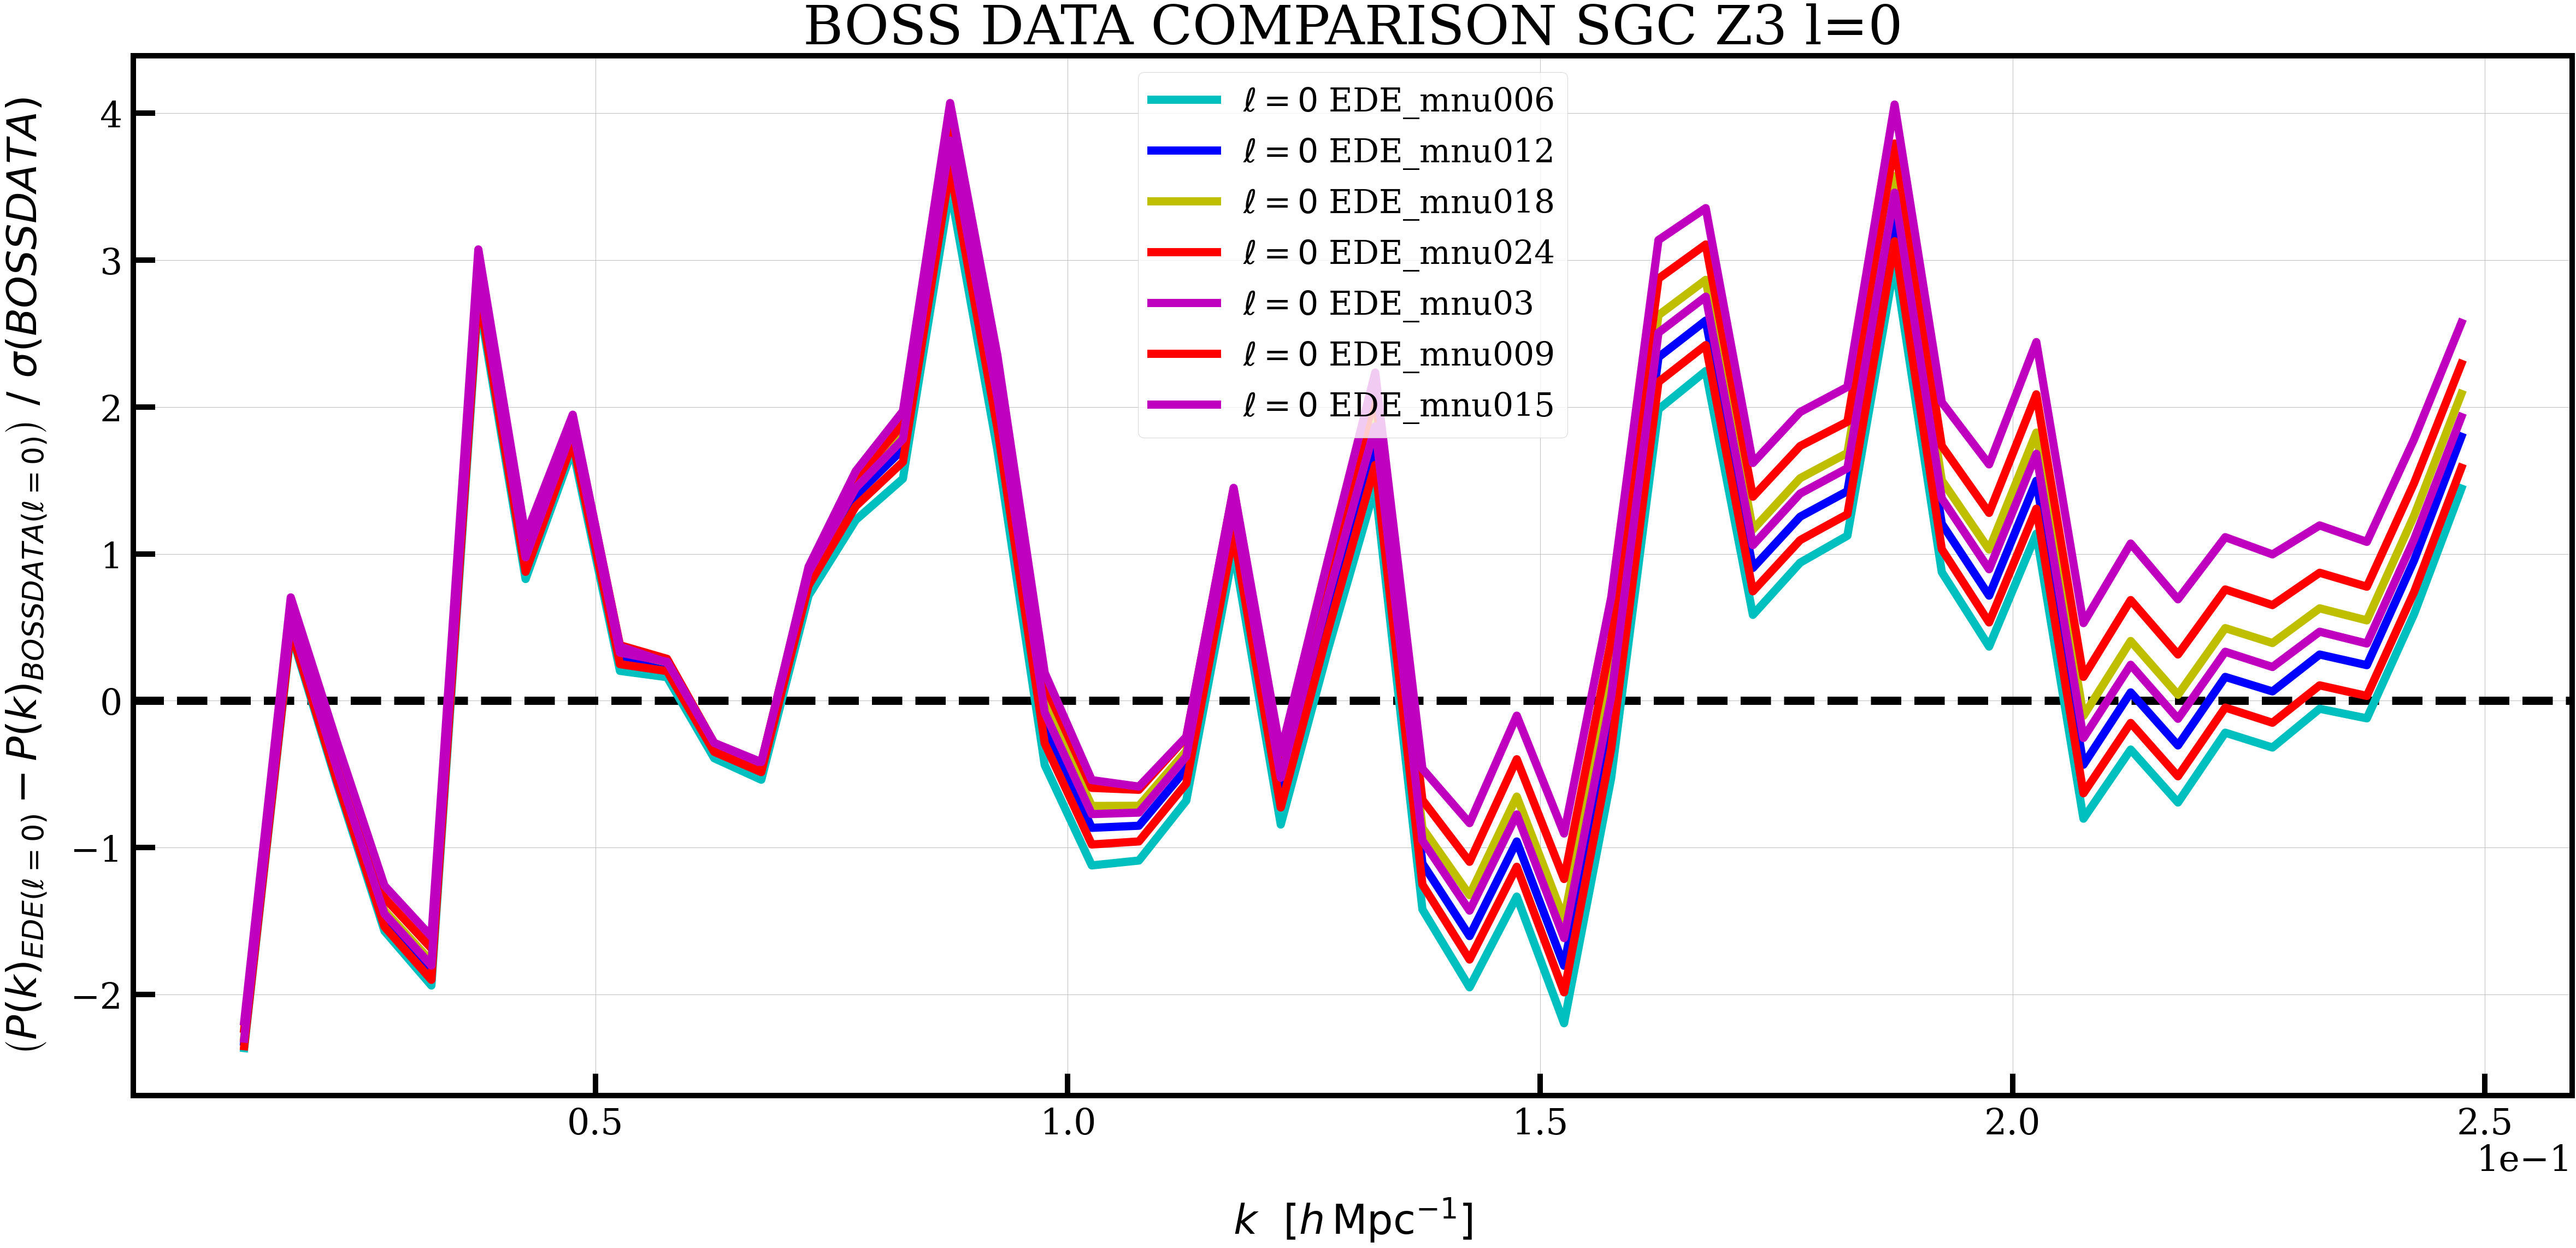

In [28]:
matplotlib.axis.YAxis.OFFSETTEXTPAD = 25
fig, ax2 = plt.subplots(figsize=(80,35))


ax2.grid()
ax2.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax2.axhline(0,c='k',lw=15,ls='--')

# ax2.plot(kvec,np.array(pk_g0_EDE_fiducial)*kvec,color='b',lw = 20, label=r'$\ell = 0$ EDE_fiducial')
ax2.plot(kvalsz3,np.array(pk_g0_EDE_pp_ratioz3sc),color='c', markersize=100, lw=15, label=r'$\ell = 0$ EDE_mnu006')
ax2.plot(kvalsz3,np.array(pk_g0_EDE_mnu012_ratioz3sc),color='b', markersize=100,lw=15,  label=r'$\ell = 0$ EDE_mnu012')
ax2.plot(kvalsz3,np.array(pk_g0_EDE_mnu018_ratioz3sc), markersize=100, color='y',lw=15, label=r'$\ell = 0$ EDE_mnu018')
ax2.plot(kvalsz3,np.array(pk_g0_EDE_mnu024_ratioz3sc),color='r', markersize=100,lw=15, label=r'$\ell = 0$ EDE_mnu024')
ax2.plot(kvalsz3,np.array(pk_g0_EDE_mnu03_ratioz3sc),color='m', markersize=100,lw=15, label=r'$\ell = 0$ EDE_mnu03')
ax2.plot(kvalsz3,np.array(pk_g0_EDE_mnu009_ratioz3sc),color='r', markersize=100,lw=15, label=r'$\ell = 0$ EDE_mnu009')
ax2.plot(kvalsz3,np.array(pk_g0_EDE_mnu015_ratioz3sc),color='m', markersize=100,lw=15, label=r'$\ell = 0$ EDE_mnu015')

ax2.set_xlabel(r'$k$  $[h\, {\rm Mpc}^{-1}]$')
ax2.set_ylabel(r'$ \left( P(k)_{EDE (\ell =0)} - P(k)_{BOSS DATA (\ell =0)} \right) ~ \left/ ~ \sigma(BOSS DATA) \right.$',labelpad=40)#,fontsize=25)
ax2.tick_params(pad=20)
ax2.tick_params(which='major',axis='x', length=40, width=10, direction='in')
ax2.tick_params(which='minor',axis='x', length=25, width=5, direction='in')
ax2.tick_params(which='major',axis='y', length=40, width=10, direction='in')
ax2.tick_params(which='minor',axis='y', length=25, width=5, direction='in')



ax2.legend(loc='best')

ax2.set_title('BOSS DATA COMPARISON SGC Z3 l=0', fontsize=100)

fig.savefig('multipoles_comparison_residual_l=0z3.pdf',bbox_inches='tight')

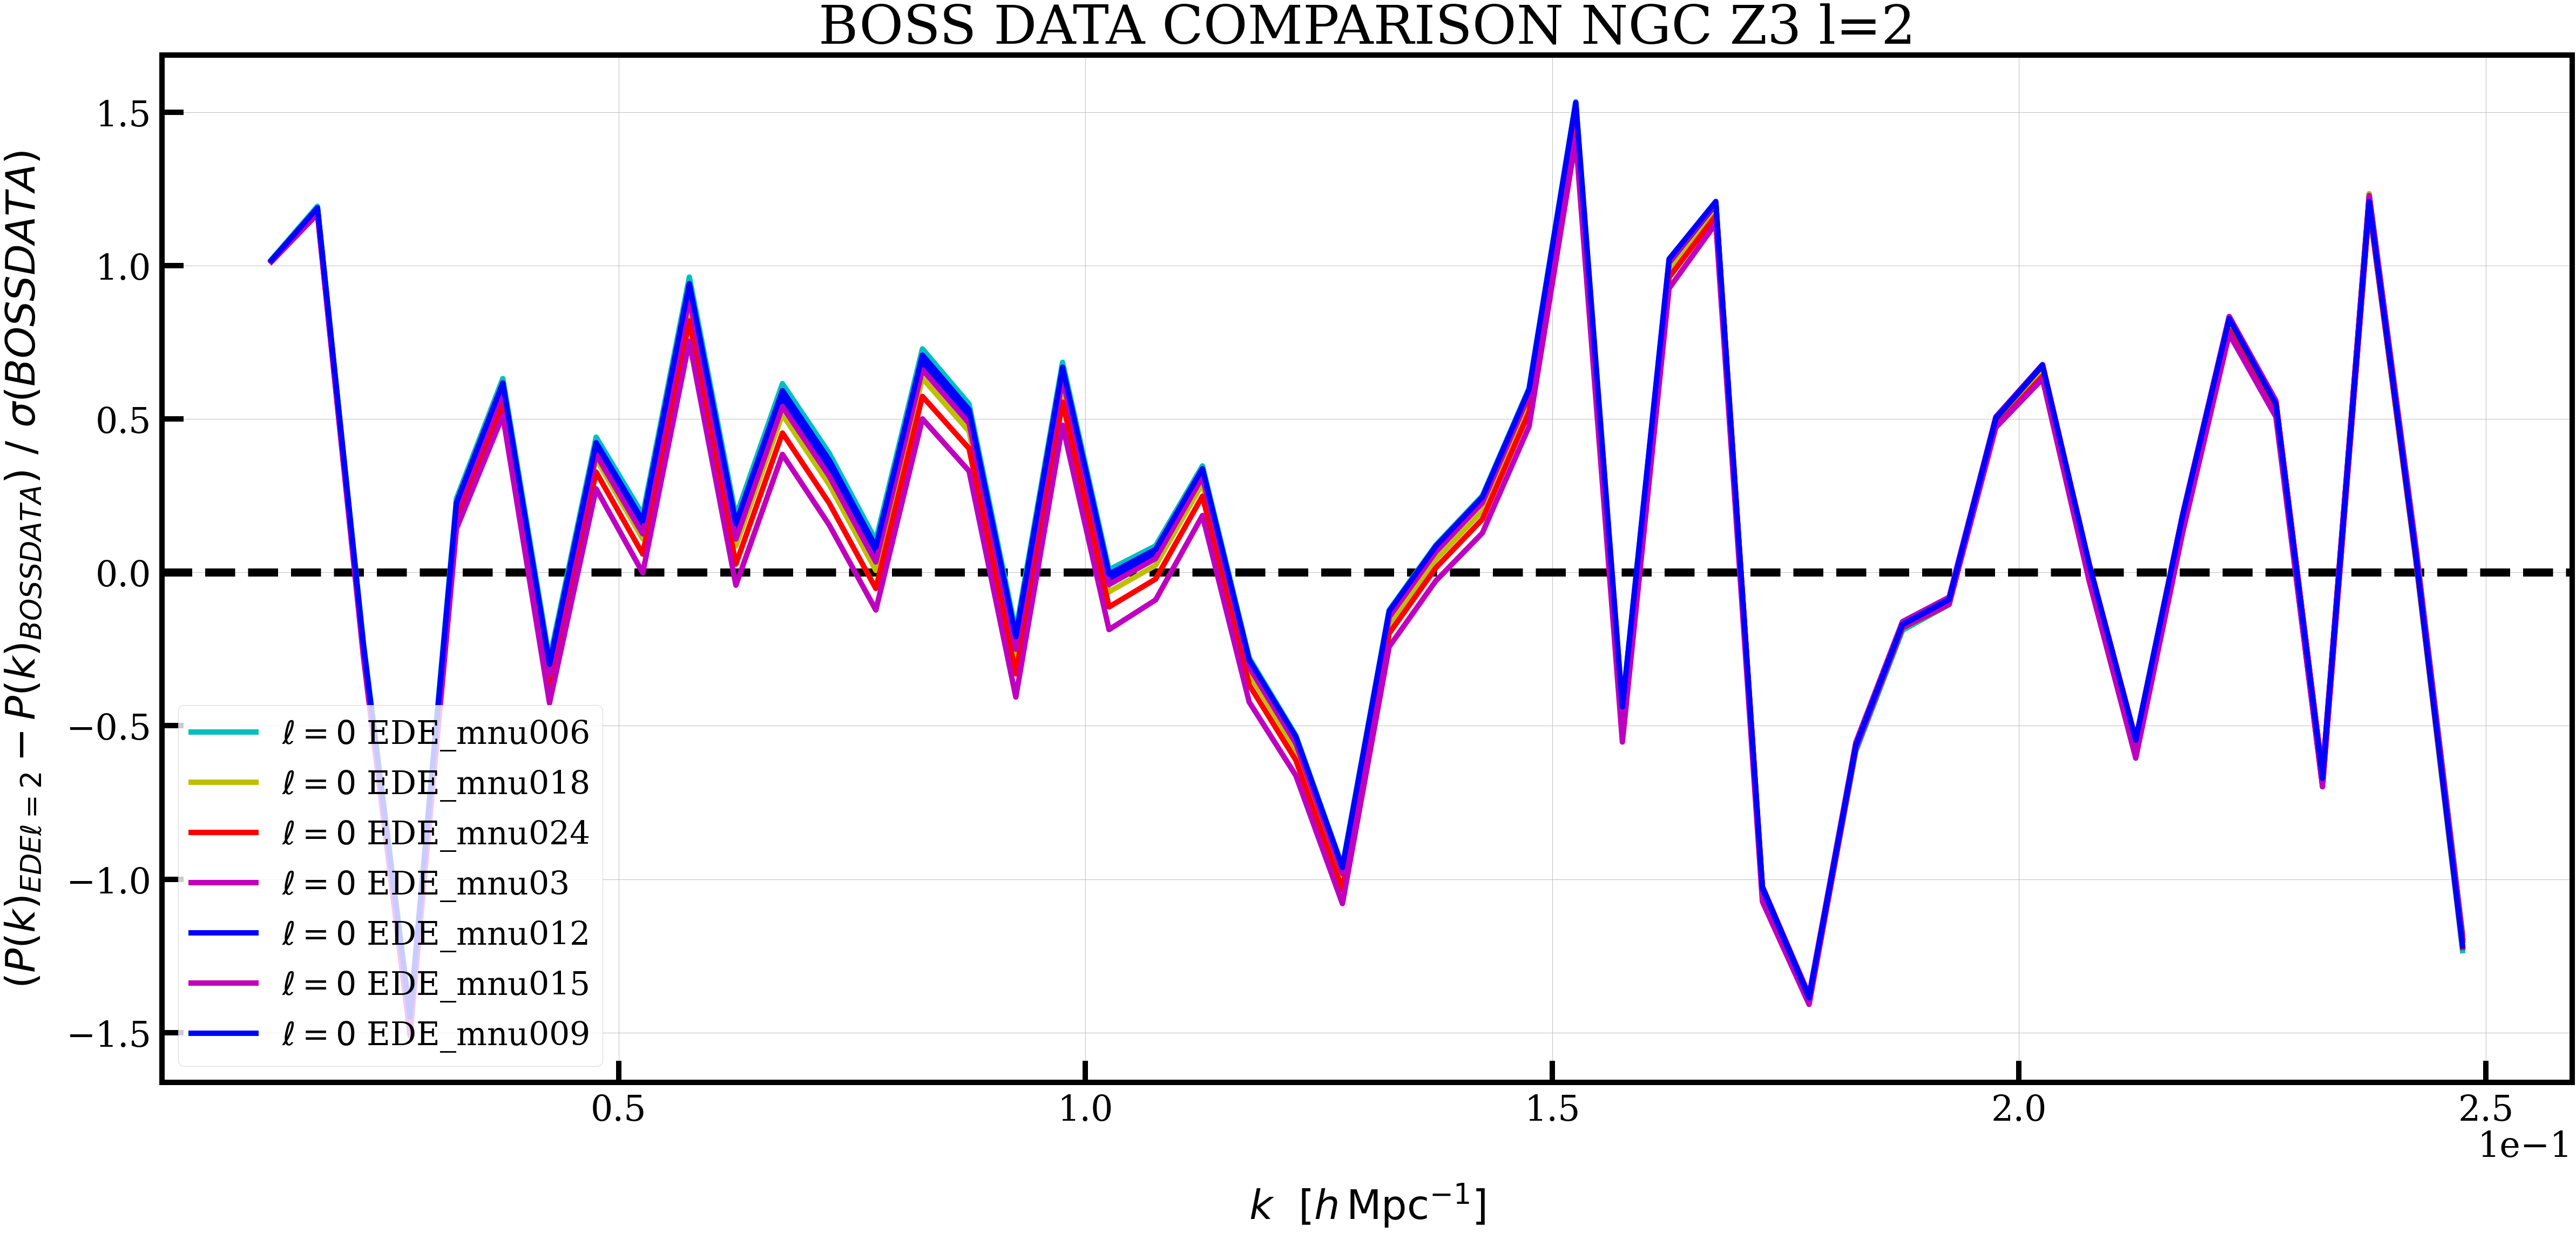

In [29]:
matplotlib.axis.YAxis.OFFSETTEXTPAD = 25
fig, ax3 = plt.subplots(figsize=(80,35))


ax3.grid()
ax3.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax3.axhline(0,c='k',lw=15,ls='--')

ax3.plot(kvalsz3,np.array(pk_g2_EDE_pp_ratioz3),color='c', lw = 10, label=r'$\ell = 0$ EDE_mnu006')
ax3.plot(kvalsz3,np.array(pk_g2_EDE_mnu018_ratioz3),color='y',lw = 10, label=r'$\ell = 0$ EDE_mnu018')
ax3.plot(kvalsz3,np.array(pk_g2_EDE_mnu024_ratioz3),color='r',lw = 10, label=r'$\ell = 0$ EDE_mnu024')
ax3.plot(kvalsz3,np.array(pk_g2_EDE_mnu03_ratioz3),color='m', lw = 10, label=r'$\ell = 0$ EDE_mnu03')
ax3.plot(kvalsz3,np.array(pk_g2_EDE_mnu012_ratioz3),color='b', lw = 10, label=r'$\ell = 0$ EDE_mnu012')
ax3.plot(kvalsz3,np.array(pk_g2_EDE_mnu015_ratioz3),color='m', lw = 10, label=r'$\ell = 0$ EDE_mnu015')
ax3.plot(kvalsz3,np.array(pk_g2_EDE_mnu009_ratioz3),color='b', lw = 10, label=r'$\ell = 0$ EDE_mnu009')



ax3.set_xlabel(r'$k$  $[h\, {\rm Mpc}^{-1}]$')
ax3.set_ylabel(r'$ \left( P(k)_{EDE \ell = 2} - P(k)_{BOSS DATA} \right) ~ \left/ ~ \sigma(BOSS DATA)  \right.$',labelpad=40)#,fontsize=25)
ax3.tick_params(pad=20)
ax3.tick_params(which='major',axis='x', length=40, width=10, direction='in')
ax3.tick_params(which='minor',axis='x', length=25, width=5, direction='in')
ax3.tick_params(which='major',axis='y', length=40, width=10, direction='in')
ax3.tick_params(which='minor',axis='y', length=25, width=5, direction='in')

ax3.legend(loc='best')
ax3.set_title('BOSS DATA COMPARISON NGC Z3 l=2', fontsize=100)

fig.savefig('multipoles_comparison_residuals_l=2z3.pdf',bbox_inches='tight')

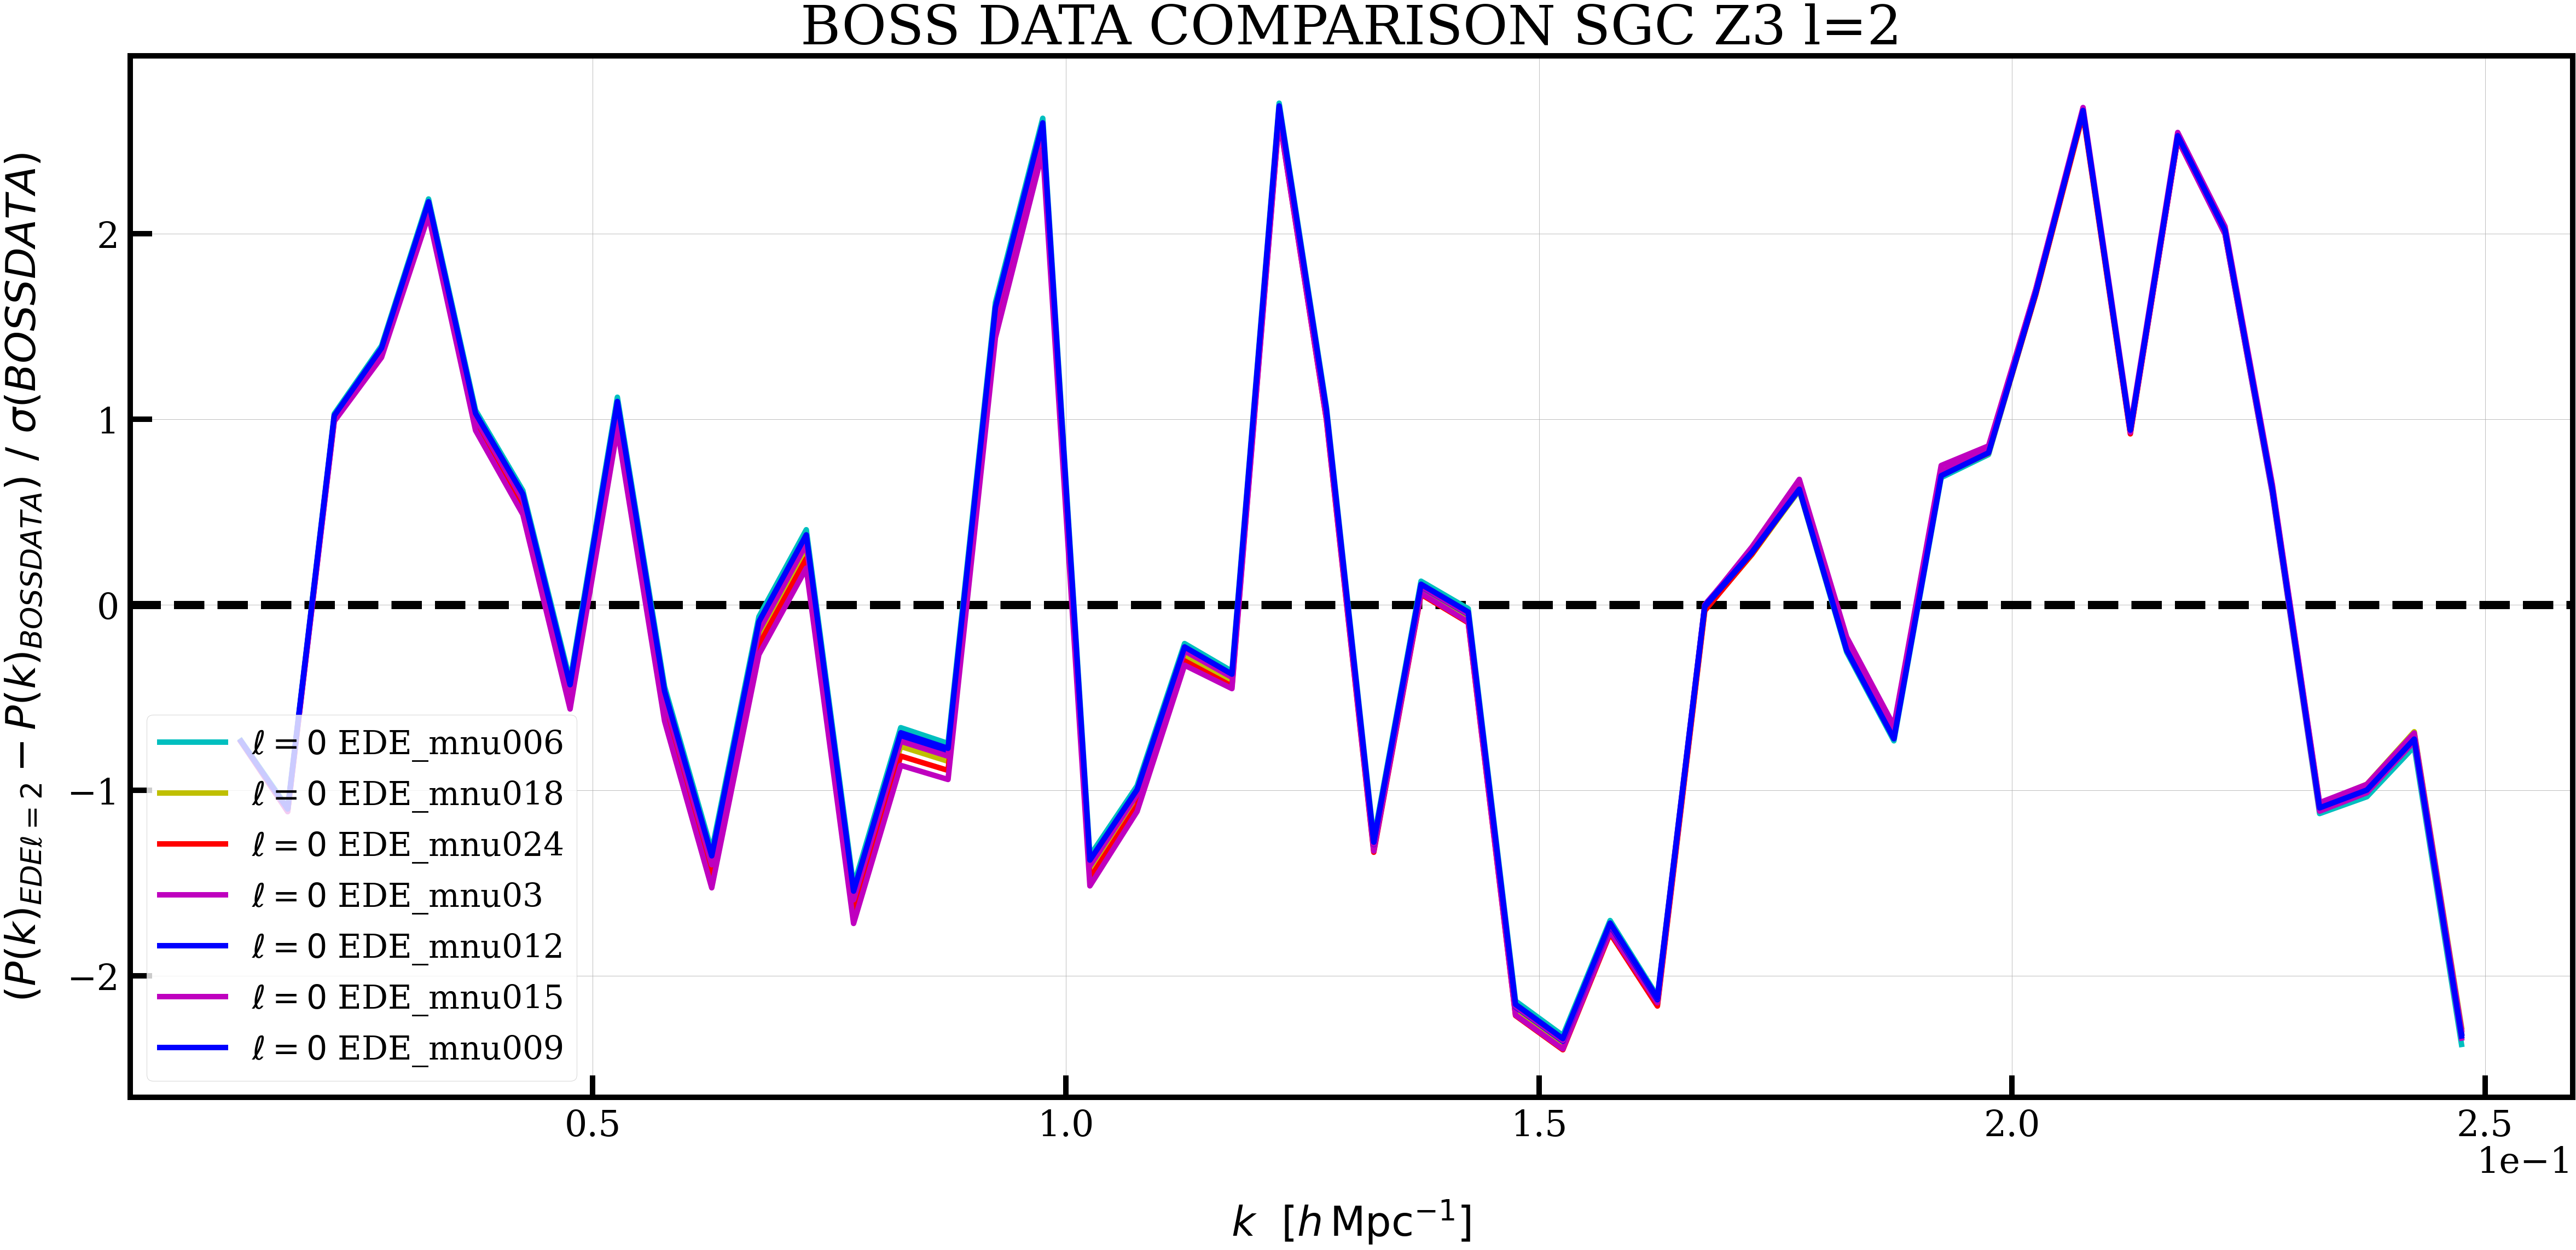

In [30]:
matplotlib.axis.YAxis.OFFSETTEXTPAD = 25
fig, ax3 = plt.subplots(figsize=(80,35))


ax3.grid()
ax3.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax3.axhline(0,c='k',lw=15,ls='--')

ax3.plot(kvalsz3,np.array(pk_g2_EDE_pp_ratioz3sc),color='c', lw = 10, label=r'$\ell = 0$ EDE_mnu006')
ax3.plot(kvalsz3,np.array(pk_g2_EDE_mnu018_ratioz3sc),color='y',lw = 10, label=r'$\ell = 0$ EDE_mnu018')
ax3.plot(kvalsz3,np.array(pk_g2_EDE_mnu024_ratioz3sc),color='r',lw = 10, label=r'$\ell = 0$ EDE_mnu024')
ax3.plot(kvalsz3,np.array(pk_g2_EDE_mnu03_ratioz3sc),color='m', lw = 10, label=r'$\ell = 0$ EDE_mnu03')
ax3.plot(kvalsz3,np.array(pk_g2_EDE_mnu012_ratioz3sc),color='b', lw = 10, label=r'$\ell = 0$ EDE_mnu012')
ax3.plot(kvalsz3,np.array(pk_g2_EDE_mnu015_ratioz3sc),color='m', lw = 10, label=r'$\ell = 0$ EDE_mnu015')
ax3.plot(kvalsz3,np.array(pk_g2_EDE_mnu009_ratioz3sc),color='b', lw = 10, label=r'$\ell = 0$ EDE_mnu009')



ax3.set_xlabel(r'$k$  $[h\, {\rm Mpc}^{-1}]$')
ax3.set_ylabel(r'$ \left( P(k)_{EDE \ell = 2} - P(k)_{BOSS DATA} \right) ~ \left/ ~ \sigma(BOSS DATA)  \right.$',labelpad=40)#,fontsize=25)
ax3.tick_params(pad=20)
ax3.tick_params(which='major',axis='x', length=40, width=10, direction='in')
ax3.tick_params(which='minor',axis='x', length=25, width=5, direction='in')
ax3.tick_params(which='major',axis='y', length=40, width=10, direction='in')
ax3.tick_params(which='minor',axis='y', length=25, width=5, direction='in')

ax3.legend(loc='best')
ax3.set_title('BOSS DATA COMPARISON SGC Z3 l=2', fontsize = 100)

fig.savefig('multipoles_comparison_residuals_l=2z3.pdf',bbox_inches='tight')

# Now Let's consider the low redshift bin

Have to consider these differently as use different k-values 

In [31]:
pk_total_EDE_ppz1, kvalsz1, p0_EDE_ppz1, p2_EDE_ppz1 = get_theory_pk(EDE_pp, z1,ksize, 'ngc_z1', dic=mnu_006_dict)
pk_total_EDE_mnu012z1, kvalsz1, a,b = get_theory_pk(EDE_mnu012, z1,ksize, 'ngc_z1', dic=mnu_012_dict)
pk_total_EDE_mnu018z1, kvalsz1,a,b = get_theory_pk(EDE_mnu018, z1,ksize, 'ngc_z1', dic=mnu_018_dict)
pk_total_EDE_mnu024z1, kvalsz1,a,b = get_theory_pk(EDE_mnu024, z1,ksize, 'ngc_z1', dic=mnu_024_dict)
pk_total_EDE_mnu03z1, kvalsz1,a,b = get_theory_pk(EDE_mnu03, z1,ksize, 'ngc_z1', dic=mnu_03_dict)
pk_total_EDE_mnu009z1, kvalsz1,a,b = get_theory_pk(EDE_mnu009, z1,ksize, 'ngc_z1', dic=mnu_009_dict)
pk_total_EDE_mnu015z1, kvalsz1,a,b = get_theory_pk(EDE_mnu015, z1,ksize, 'ngc_z1', dic=mnu_015_dict)

In [32]:
pk_total_EDE_ppz1sc, kvalsz1sc, p0_EDE_ppz1, p2_EDE_ppz1 = get_theory_pk(EDE_pp, z1,ksize, 'sgc_z1', dic=mnu_006_dict)
pk_total_EDE_mnu012z1sc, kvalsz1sc, a,b = get_theory_pk(EDE_mnu012, z1,ksize, 'sgc_z1', dic=mnu_012_dict)
pk_total_EDE_mnu018z1sc, kvalsz1sc,a,b = get_theory_pk(EDE_mnu018, z1,ksize, 'sgc_z1', dic=mnu_018_dict)
pk_total_EDE_mnu024z1sc, kvalsz1sc,a,b = get_theory_pk(EDE_mnu024, z1,ksize, 'sgc_z1', dic=mnu_024_dict)
pk_total_EDE_mnu03z1sc, kvalsz1sc,a,b = get_theory_pk(EDE_mnu03, z1,ksize, 'sgc_z1', dic=mnu_03_dict)
pk_total_EDE_mnu009z1sc, kvalsz1sc,a,b = get_theory_pk(EDE_mnu009, z1,ksize, 'sgc_z1', dic=mnu_009_dict)
pk_total_EDE_mnu015z1sc, kvalsz1sc,a,b = get_theory_pk(EDE_mnu015, z1,ksize, 'sgc_z1', dic=mnu_015_dict)

### Compute the residuals with the data

In [33]:
#################################################################################################
#----------------------------------------NGC----------------------------------------------------#

pk_g0_EDE_pp_ratioz1 = (pk_total_EDE_ppz1[0:48]-p0kz1)/(sigmasz1[0:48]) 
pk_g2_EDE_pp_ratioz1 = (pk_total_EDE_ppz1[48:]-p2kz1)/(sigmasz1[48:]) 

pk_g0_EDE_mnu012_ratioz1 = (pk_total_EDE_mnu012z1[0:48]-p0kz1)/(sigmasz1[0:48])  
pk_g2_EDE_mnu012_ratioz1 = (pk_total_EDE_mnu012z1[48:]-p2kz1)/(sigmasz1[48:])  

pk_g0_EDE_mnu018_ratioz1 = (pk_total_EDE_mnu018z1[0:48]-p0kz1)/(sigmasz1[0:48])  
pk_g2_EDE_mnu018_ratioz1 = (pk_total_EDE_mnu018z1[48:]-p2kz1)/(sigmasz1[48:])  

pk_g0_EDE_mnu024_ratioz1 = (pk_total_EDE_mnu024z1[0:48]-p0kz1)/(sigmasz1[0:48])  
pk_g2_EDE_mnu024_ratioz1 = (pk_total_EDE_mnu024z1[48:]-p2kz1)/(sigmasz1[48:]) 

pk_g0_EDE_mnu03_ratioz1 = (pk_total_EDE_mnu03z1[0:48]-p0kz1)/(sigmasz1[0:48]) 
pk_g2_EDE_mnu03_ratioz1 = (pk_total_EDE_mnu03z1[48:]-p2kz1)/(sigmasz1[48:]) 

pk_g0_EDE_mnu009_ratioz1 = (pk_total_EDE_mnu009z1[0:48]-p0kz1)/(sigmasz1[0:48]) 
pk_g2_EDE_mnu009_ratioz1 = (pk_total_EDE_mnu009z1[48:]-p2kz1)/(sigmasz1[48:])

pk_g0_EDE_mnu015_ratioz1 = (pk_total_EDE_mnu015z1[0:48]-p0kz1)/(sigmasz1[0:48]) 
pk_g2_EDE_mnu015_ratioz1 = (pk_total_EDE_mnu015z1[48:]-p2kz1)/(sigmasz1[48:])

#################################################################################################
#----------------------------------------SGC----------------------------------------------------# 

pk_g0_EDE_pp_ratioz1sc = (pk_total_EDE_ppz1sc[0:48]-p0kz1sc)/(sigmasz1sc[0:48]) 
pk_g2_EDE_pp_ratioz1sc = (pk_total_EDE_ppz1sc[48:]-p2kz1sc)/(sigmasz1sc[48:]) 

pk_g0_EDE_mnu012_ratioz1sc = (pk_total_EDE_mnu012z1sc[0:48]-p0kz1sc)/(sigmasz1sc[0:48])  
pk_g2_EDE_mnu012_ratioz1sc = (pk_total_EDE_mnu012z1sc[48:]-p2kz1sc)/(sigmasz1sc[48:])  

pk_g0_EDE_mnu018_ratioz1sc = (pk_total_EDE_mnu018z1sc[0:48]-p0kz1sc)/(sigmasz1sc[0:48])  
pk_g2_EDE_mnu018_ratioz1sc = (pk_total_EDE_mnu018z1sc[48:]-p2kz1sc)/(sigmasz1sc[48:])  

pk_g0_EDE_mnu024_ratioz1sc = (pk_total_EDE_mnu024z1sc[0:48]-p0kz1sc)/(sigmasz1sc[0:48])  
pk_g2_EDE_mnu024_ratioz1sc = (pk_total_EDE_mnu024z1sc[48:]-p2kz1sc)/(sigmasz1sc[48:]) 

pk_g0_EDE_mnu03_ratioz1sc = (pk_total_EDE_mnu03z1sc[0:48]-p0kz1sc)/(sigmasz1sc[0:48]) 
pk_g2_EDE_mnu03_ratioz1sc = (pk_total_EDE_mnu03z1sc[48:]-p2kz1sc)/(sigmasz1sc[48:]) 

pk_g0_EDE_mnu009_ratioz1sc = (pk_total_EDE_mnu009z1sc[0:48]-p0kz1sc)/(sigmasz1sc[0:48]) 
pk_g2_EDE_mnu009_ratioz1sc = (pk_total_EDE_mnu009z1sc[48:]-p2kz1sc)/(sigmasz1sc[48:])

pk_g0_EDE_mnu015_ratioz1sc = (pk_total_EDE_mnu015z1sc[0:48]-p0kz1sc)/(sigmasz1sc[0:48]) 
pk_g2_EDE_mnu015_ratioz1sc = (pk_total_EDE_mnu015z1sc[48:]-p2kz1sc)/(sigmasz1sc[48:])


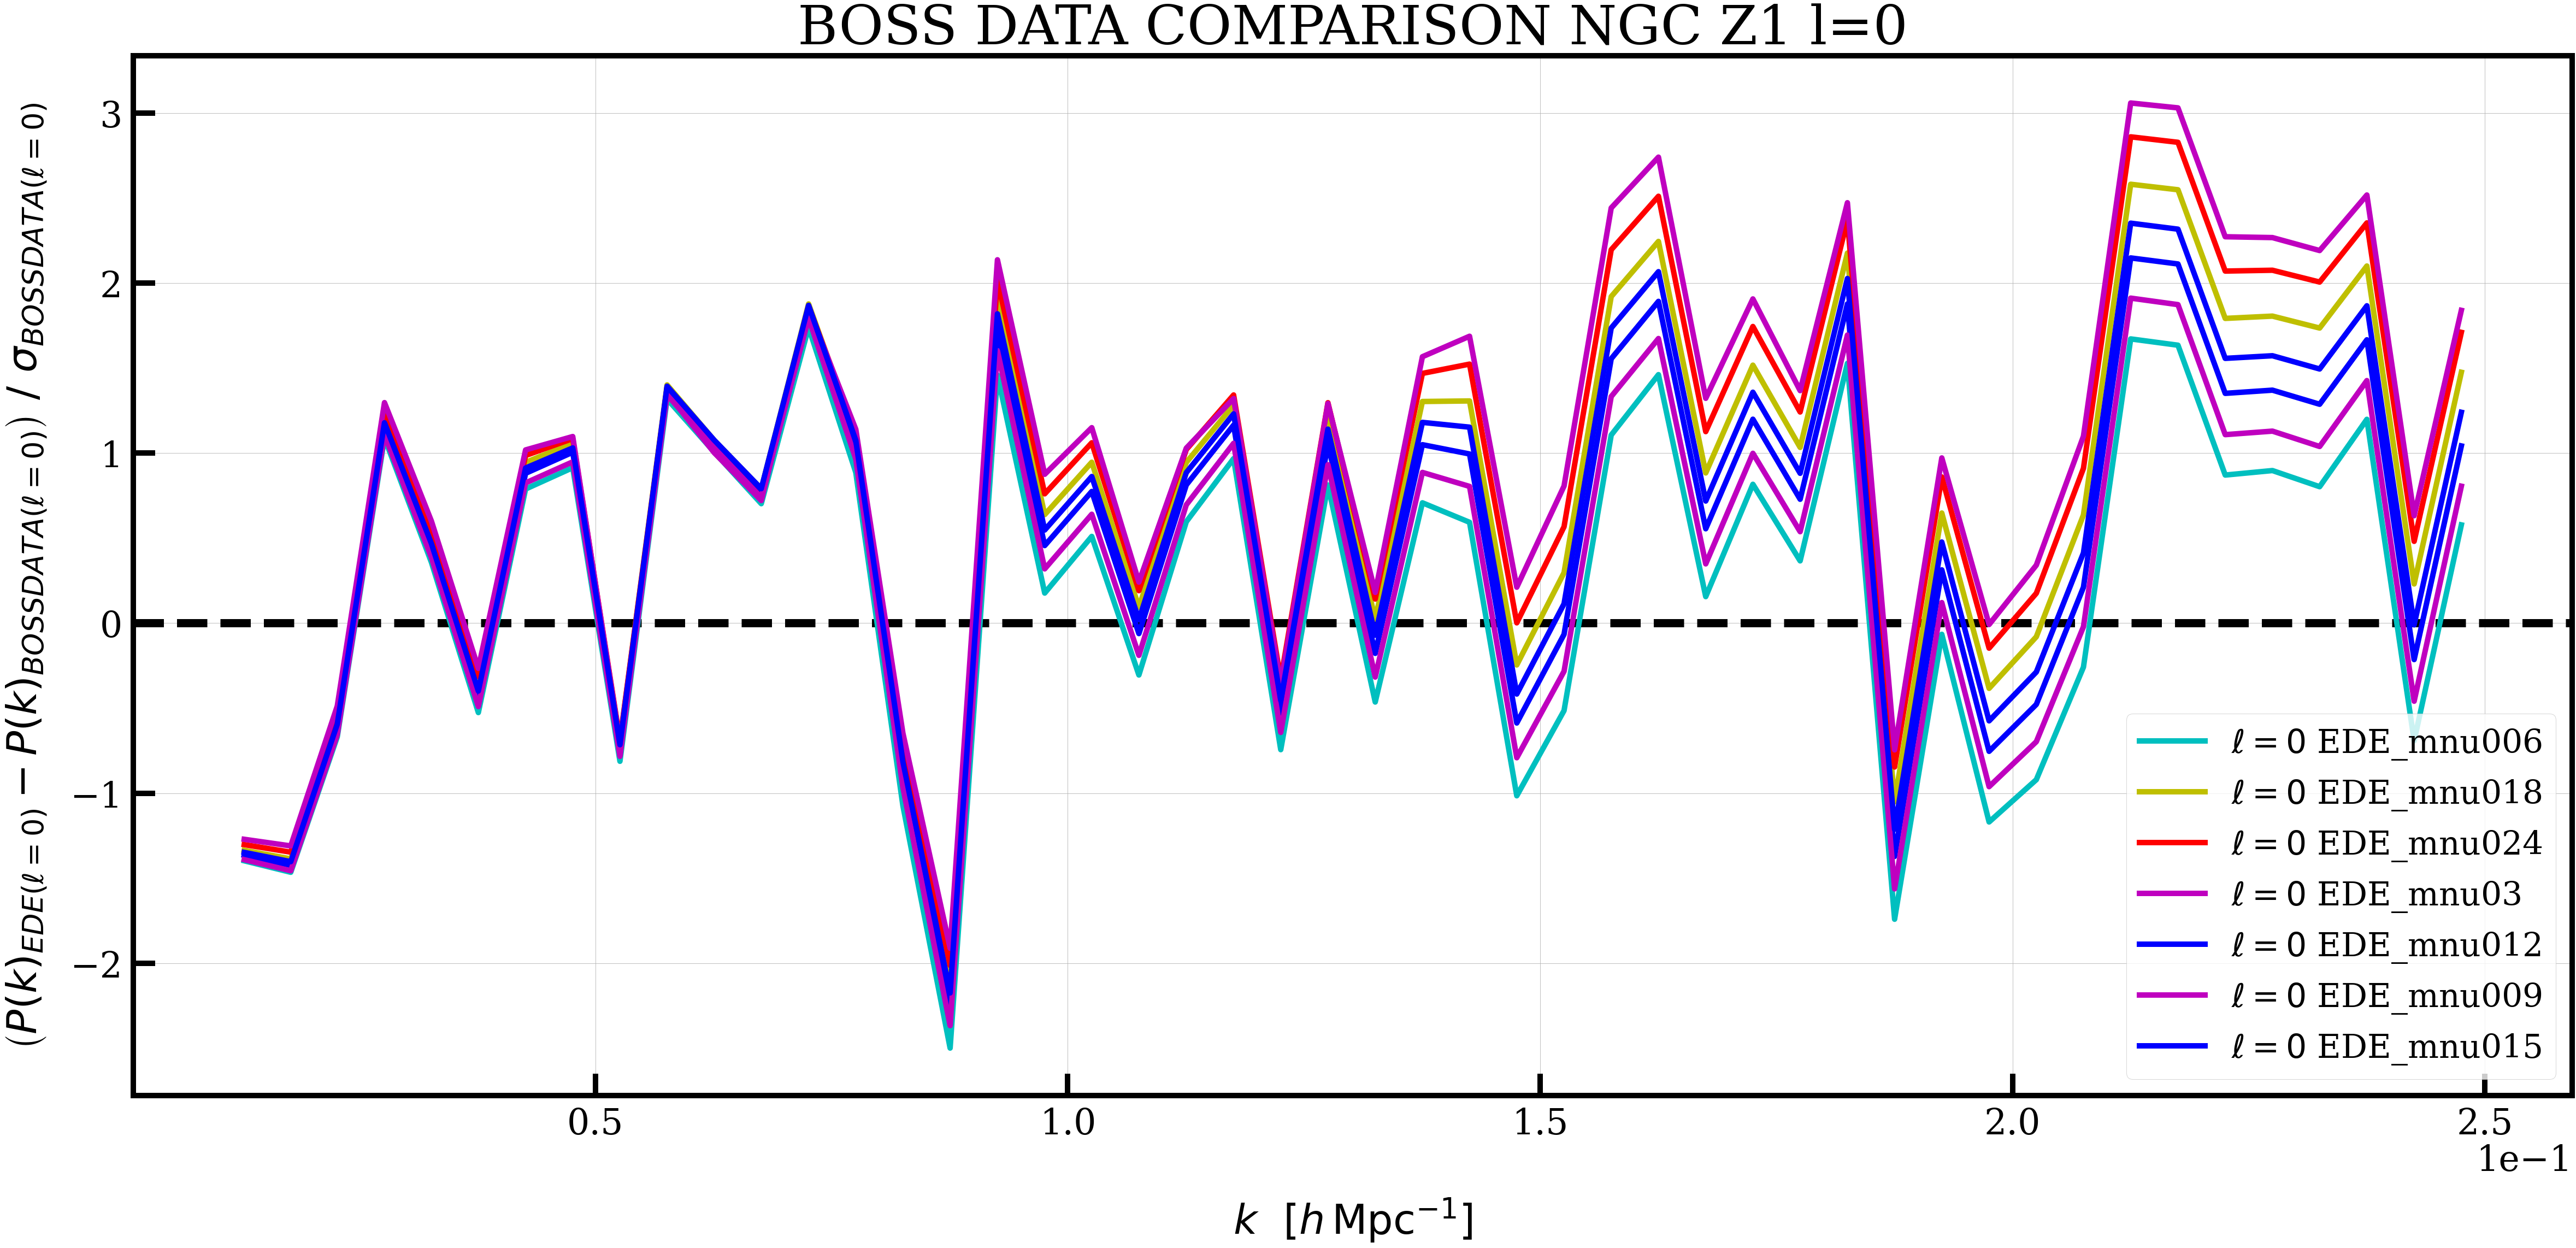

In [34]:
matplotlib.axis.YAxis.OFFSETTEXTPAD = 25
fig, ax2 = plt.subplots(figsize=(80,35))


ax2.grid()
ax2.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax2.axhline(0,c='k',lw=15,ls='--')

# ax2.plot(kvec,np.array(pk_g0_EDE_fiducial)*kvec,color='b',lw = 20, label=r'$\ell = 0$ EDE_fiducial')
ax2.plot(kvalsz1,np.array(pk_g0_EDE_pp_ratioz1),color='c', lw = 10, label=r'$\ell = 0$ EDE_mnu006')
ax2.plot(kvalsz1,np.array(pk_g0_EDE_mnu018_ratioz1),color='y',lw = 10, label=r'$\ell = 0$ EDE_mnu018')
ax2.plot(kvalsz1,np.array(pk_g0_EDE_mnu024_ratioz1),color='r',lw = 10, label=r'$\ell = 0$ EDE_mnu024')
ax2.plot(kvalsz1,np.array(pk_g0_EDE_mnu03_ratioz1),color='m', lw = 10, label=r'$\ell = 0$ EDE_mnu03')
ax2.plot(kvalsz1,np.array(pk_g0_EDE_mnu012_ratioz1),color='b', lw = 10, label=r'$\ell = 0$ EDE_mnu012')
ax2.plot(kvalsz1,np.array(pk_g0_EDE_mnu009_ratioz1),color='m', lw = 10, label=r'$\ell = 0$ EDE_mnu009')
ax2.plot(kvalsz1,np.array(pk_g0_EDE_mnu015_ratioz1),color='b', lw = 10, label=r'$\ell = 0$ EDE_mnu015')

ax2.set_xlabel(r'$k$  $[h\, {\rm Mpc}^{-1}]$')
ax2.set_ylabel(r'$ \left( P(k)_{EDE (\ell =0)} - P(k)_{BOSS DATA (\ell =0)} \right) ~ \left/ ~ \sigma_{BOSS DATA (\ell =0)} \right.$',labelpad=40)#,fontsize=25)
ax2.tick_params(pad=20)
ax2.tick_params(which='major',axis='x', length=40, width=10, direction='in')
ax2.tick_params(which='minor',axis='x', length=25, width=5, direction='in')
ax2.tick_params(which='major',axis='y', length=40, width=10, direction='in')
ax2.tick_params(which='minor',axis='y', length=25, width=5, direction='in')

ax2.legend(loc='best')


ax2.set_title('l=0 multipole comprison z1')

ax2.set_title('BOSS DATA COMPARISON NGC Z1 l=0', fontsize=100)

fig.savefig('multipoles_comparison_residual_l=0z1.pdf',bbox_inches='tight')

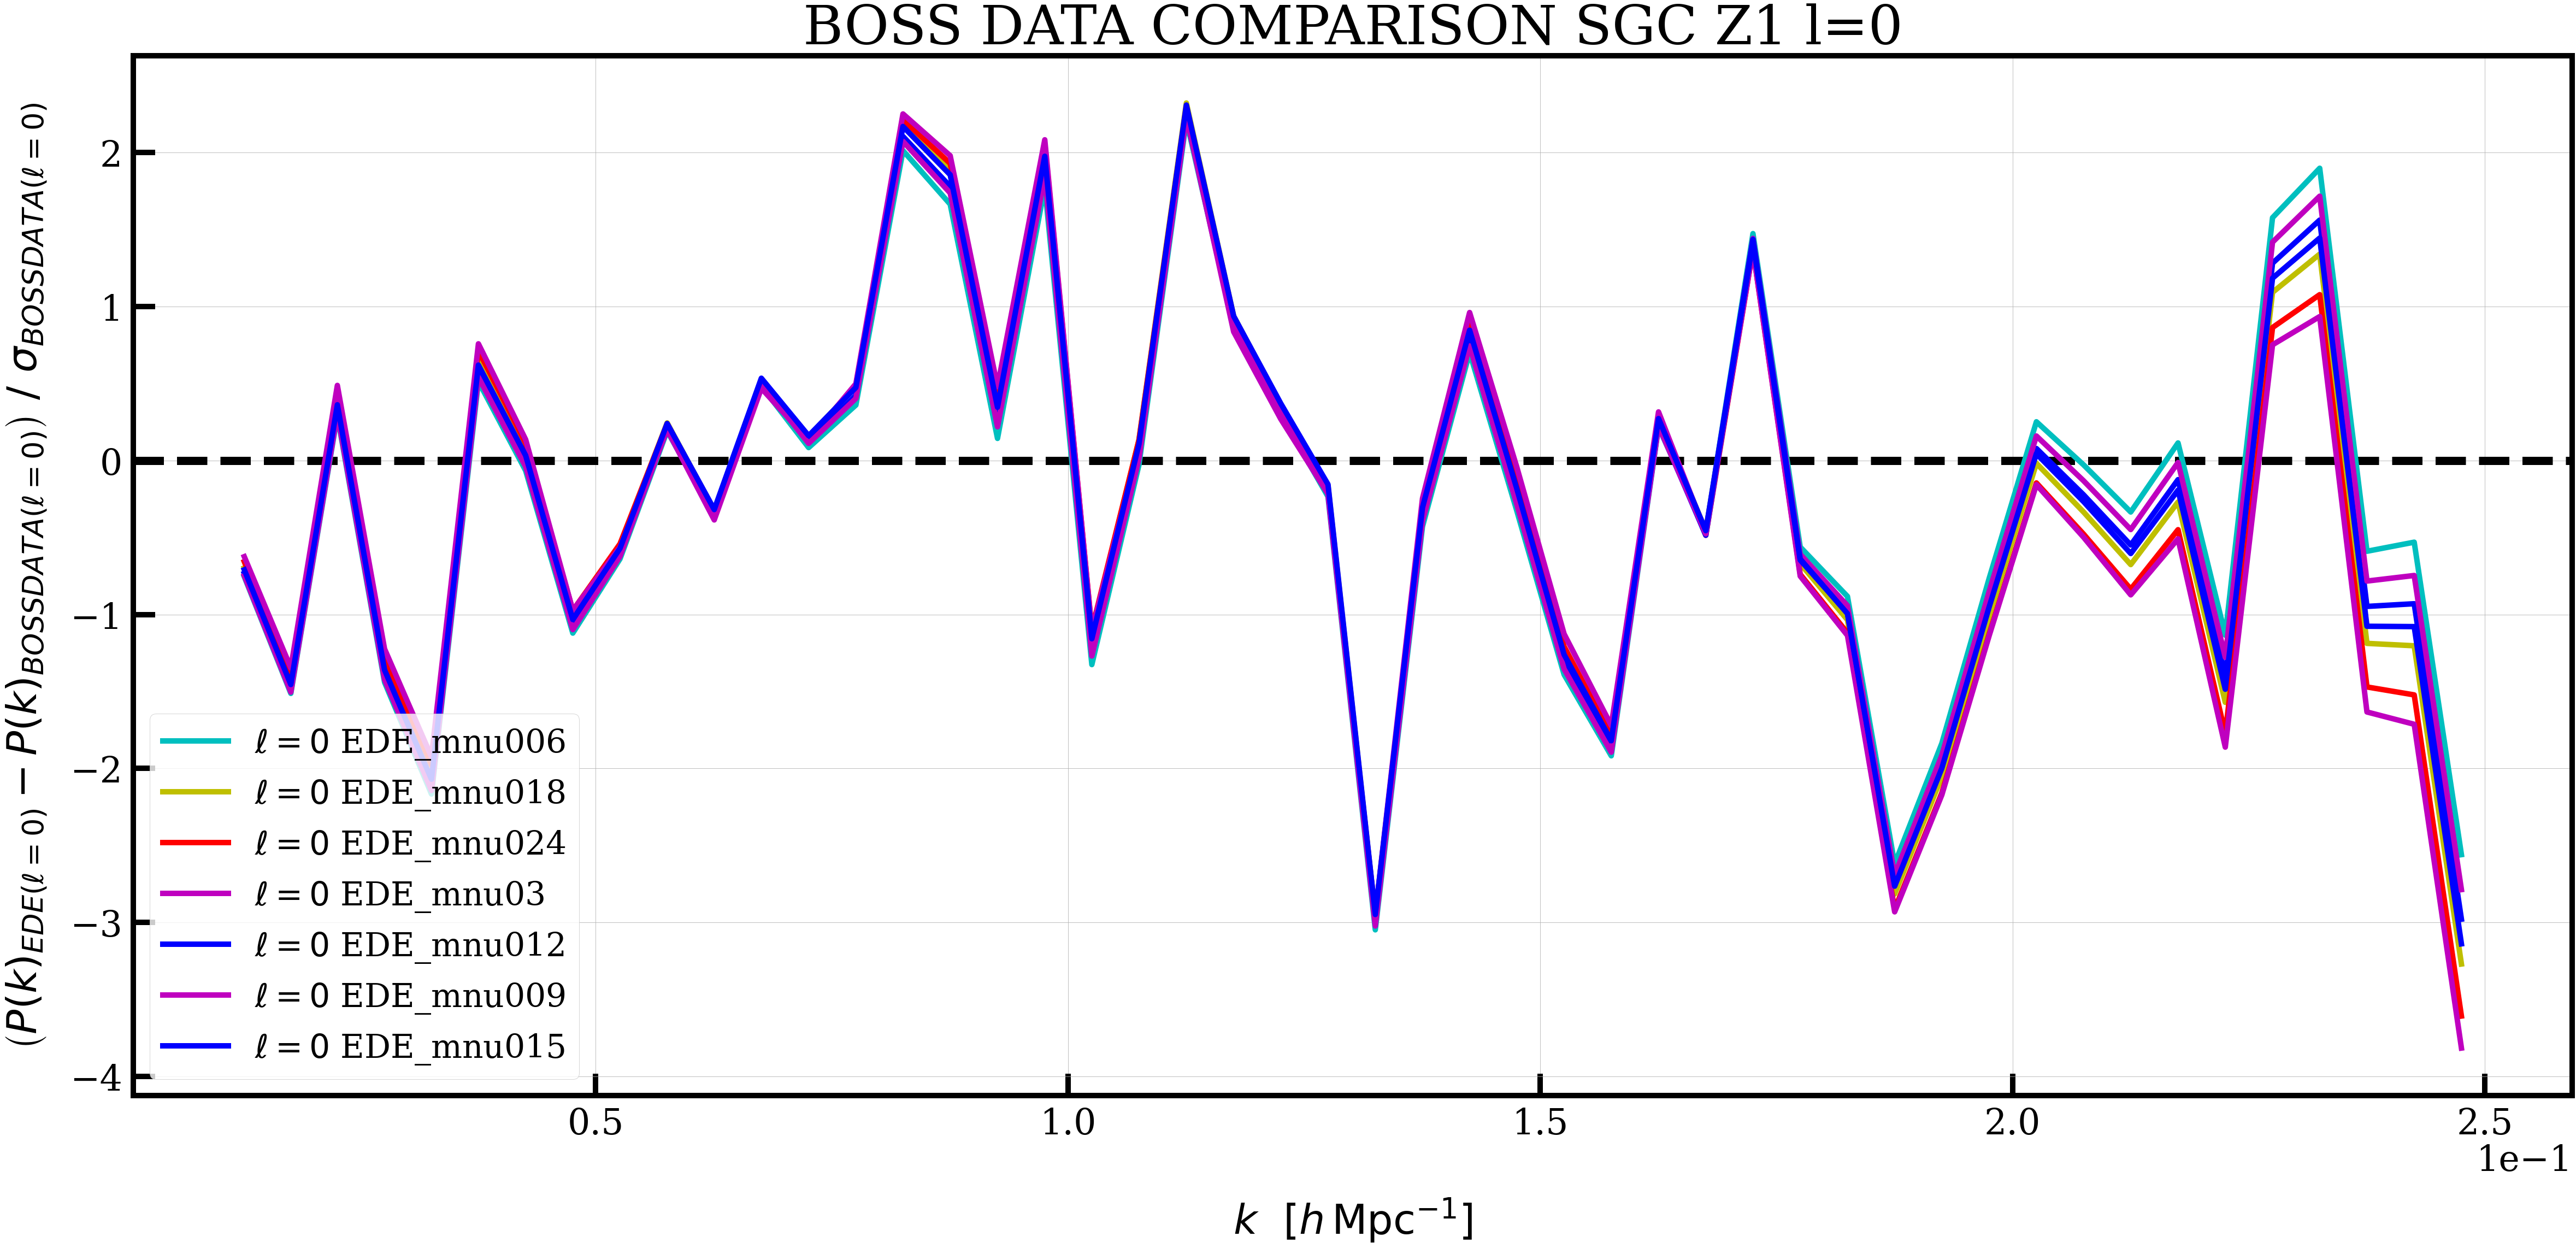

In [35]:
matplotlib.axis.YAxis.OFFSETTEXTPAD = 25
fig, ax2 = plt.subplots(figsize=(80,35))


ax2.grid()
ax2.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax2.axhline(0,c='k',lw=15,ls='--')

# ax2.plot(kvec,np.array(pk_g0_EDE_fiducial)*kvec,color='b',lw = 20, label=r'$\ell = 0$ EDE_fiducial')
ax2.plot(kvalsz1,np.array(pk_g0_EDE_pp_ratioz1sc),color='c', lw = 10, label=r'$\ell = 0$ EDE_mnu006')
ax2.plot(kvalsz1,np.array(pk_g0_EDE_mnu018_ratioz1sc),color='y',lw = 10, label=r'$\ell = 0$ EDE_mnu018')
ax2.plot(kvalsz1,np.array(pk_g0_EDE_mnu024_ratioz1sc),color='r',lw = 10, label=r'$\ell = 0$ EDE_mnu024')
ax2.plot(kvalsz1,np.array(pk_g0_EDE_mnu03_ratioz1sc),color='m', lw = 10, label=r'$\ell = 0$ EDE_mnu03')
ax2.plot(kvalsz1,np.array(pk_g0_EDE_mnu012_ratioz1sc),color='b', lw = 10, label=r'$\ell = 0$ EDE_mnu012')
ax2.plot(kvalsz1,np.array(pk_g0_EDE_mnu009_ratioz1sc),color='m', lw = 10, label=r'$\ell = 0$ EDE_mnu009')
ax2.plot(kvalsz1,np.array(pk_g0_EDE_mnu015_ratioz1sc),color='b', lw = 10, label=r'$\ell = 0$ EDE_mnu015')

ax2.set_xlabel(r'$k$  $[h\, {\rm Mpc}^{-1}]$')
ax2.set_ylabel(r'$ \left( P(k)_{EDE (\ell =0)} - P(k)_{BOSS DATA (\ell =0)} \right) ~ \left/ ~ \sigma_{BOSS DATA (\ell =0)} \right.$',labelpad=40)#,fontsize=25)
ax2.tick_params(pad=20)
ax2.tick_params(which='major',axis='x', length=40, width=10, direction='in')
ax2.tick_params(which='minor',axis='x', length=25, width=5, direction='in')
ax2.tick_params(which='major',axis='y', length=40, width=10, direction='in')
ax2.tick_params(which='minor',axis='y', length=25, width=5, direction='in')


ax2.legend(loc='best')


ax2.set_title('BOSS DATA COMPARISON SGC Z1 l=0', fontsize=100)

fig.savefig('multipoles_comparison_residual_l=0z1.pdf',bbox_inches='tight')

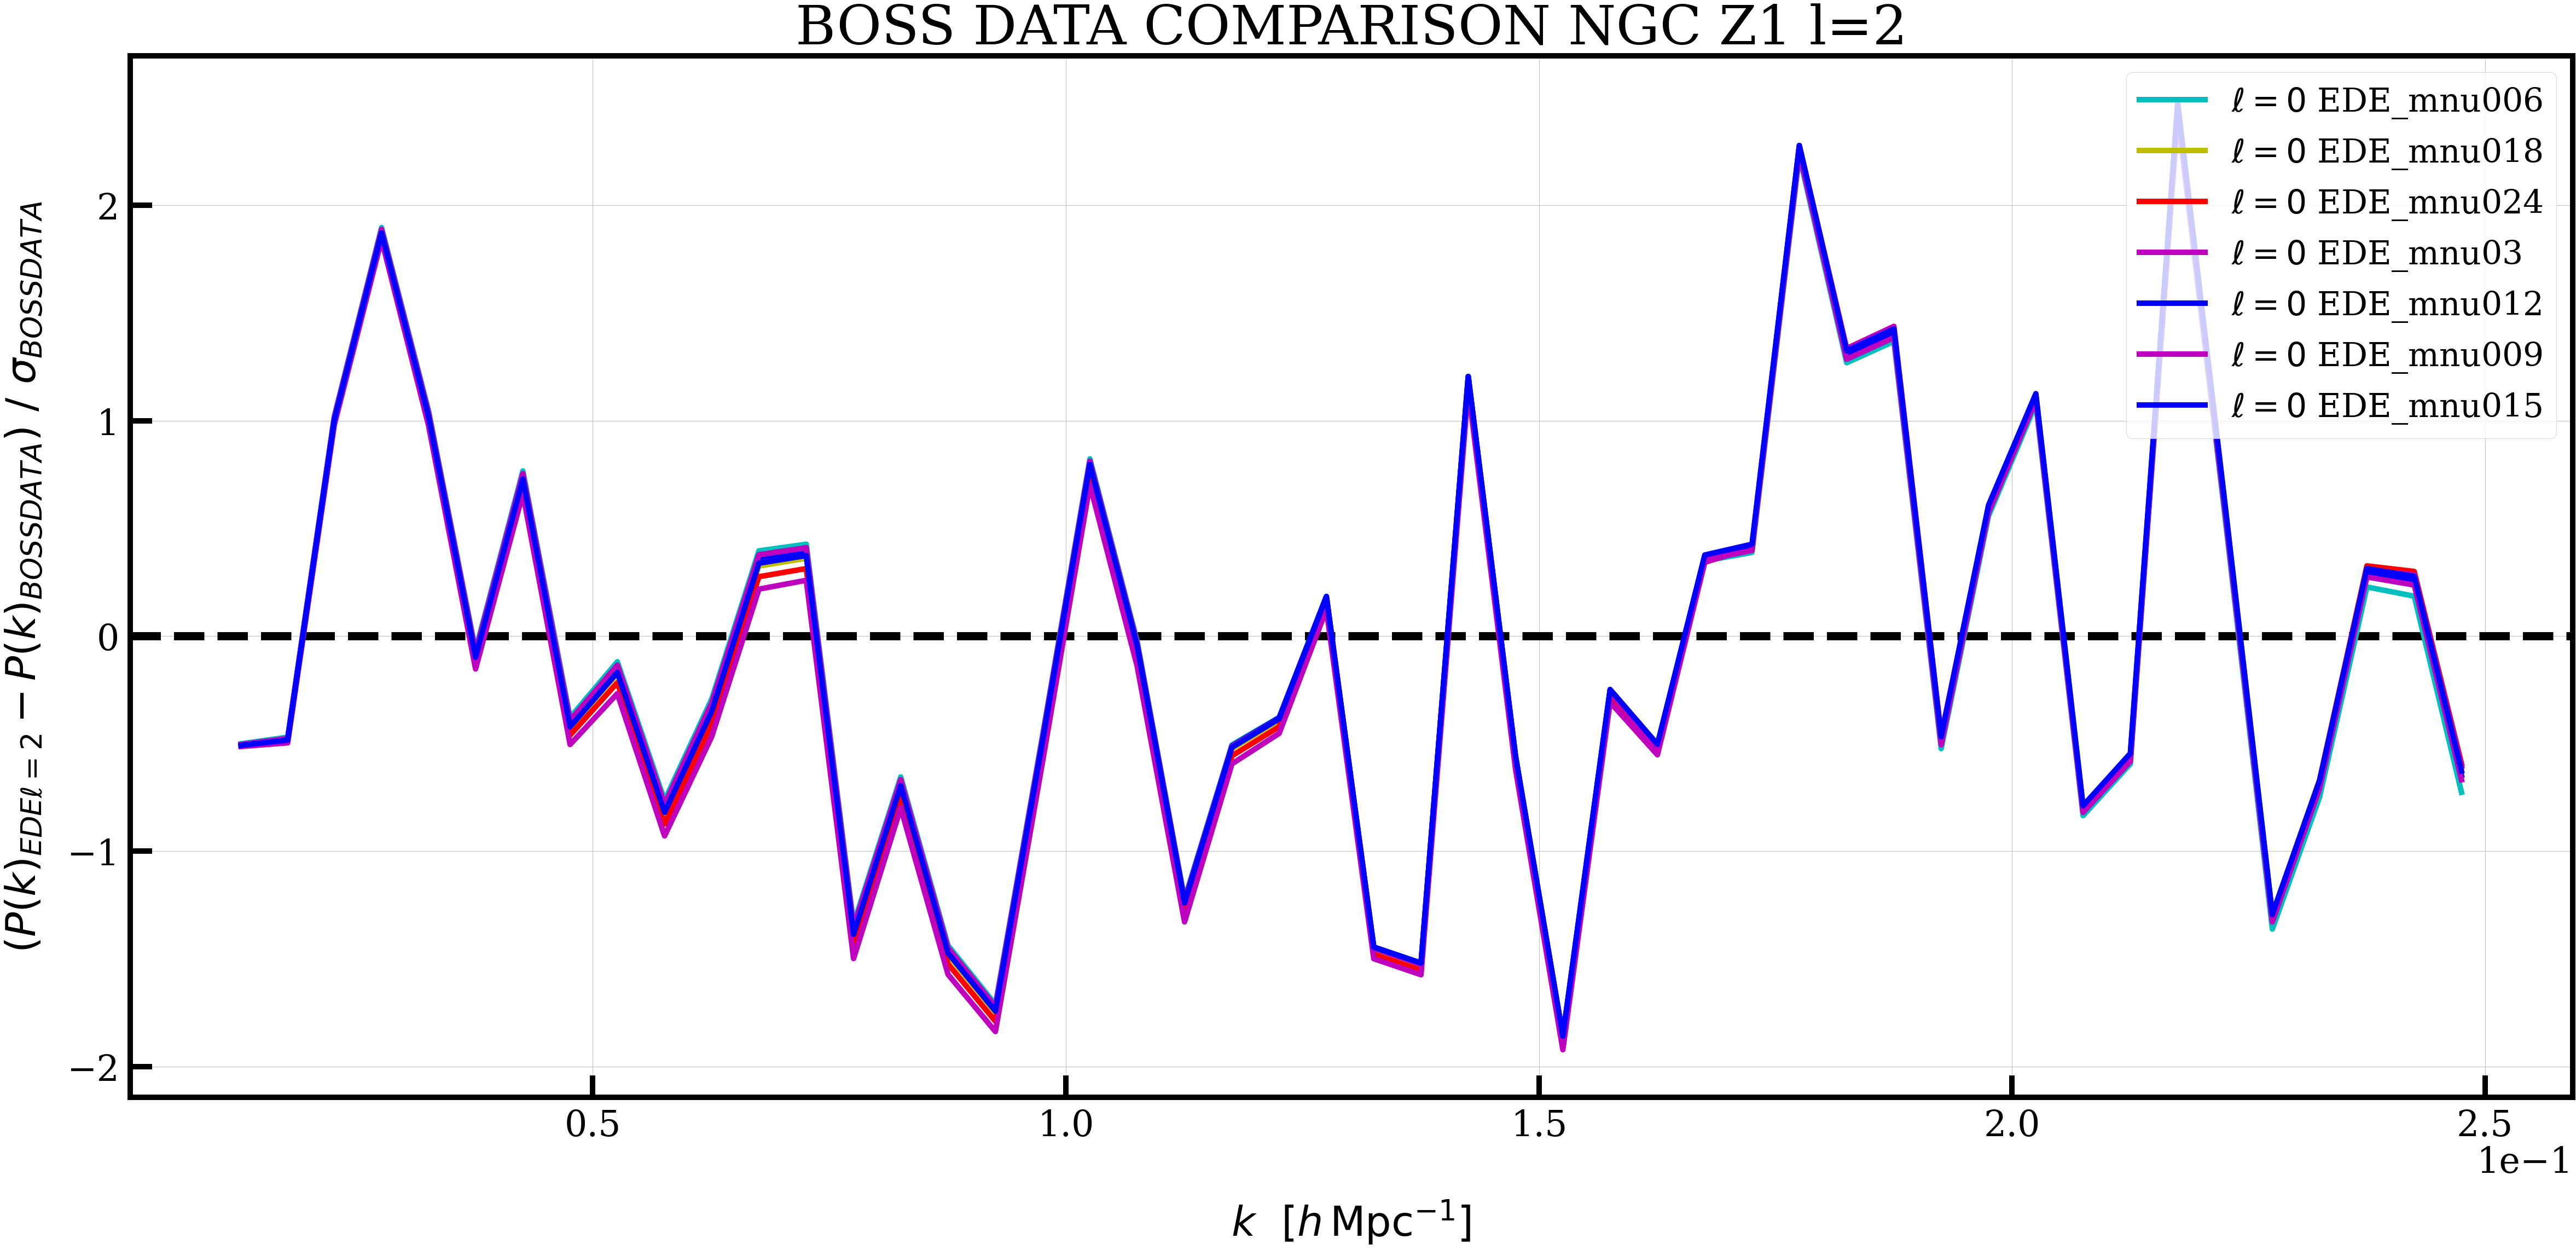

In [36]:
matplotlib.axis.YAxis.OFFSETTEXTPAD = 25
fig, ax3 = plt.subplots(figsize=(80,35))


ax3.grid()
ax3.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax3.axhline(0,c='k',lw=15,ls='--')

ax3.plot(kvalsz1,np.array(pk_g2_EDE_pp_ratioz1),color='c', lw = 10, label=r'$\ell = 0$ EDE_mnu006')
ax3.plot(kvalsz1,np.array(pk_g2_EDE_mnu018_ratioz1),color='y',lw = 10, label=r'$\ell = 0$ EDE_mnu018')
ax3.plot(kvalsz1,np.array(pk_g2_EDE_mnu024_ratioz1),color='r',lw = 10, label=r'$\ell = 0$ EDE_mnu024')
ax3.plot(kvalsz1,np.array(pk_g2_EDE_mnu03_ratioz1),color='m', lw = 10, label=r'$\ell = 0$ EDE_mnu03')
ax3.plot(kvalsz1,np.array(pk_g2_EDE_mnu012_ratioz1),color='b', lw = 10, label=r'$\ell = 0$ EDE_mnu012')
ax3.plot(kvalsz1,np.array(pk_g2_EDE_mnu009_ratioz1),color='m', lw = 10, label=r'$\ell = 0$ EDE_mnu009')
ax3.plot(kvalsz1,np.array(pk_g2_EDE_mnu015_ratioz1),color='b', lw = 10, label=r'$\ell = 0$ EDE_mnu015')

ax3.set_xlabel(r'$k$  $[h\, {\rm Mpc}^{-1}]$')
ax3.set_ylabel(r'$ \left( P(k)_{EDE \ell = 2} - P(k)_{BOSS DATA} \right) ~ \left/ ~ \sigma_{BOSS DATA} \right.$',labelpad=40)#,fontsize=25)
ax3.tick_params(pad=20)
ax3.tick_params(which='major',axis='x', length=40, width=10, direction='in')
ax3.tick_params(which='minor',axis='x', length=25, width=5, direction='in')
ax3.tick_params(which='major',axis='y', length=40, width=10, direction='in')
ax3.tick_params(which='minor',axis='y', length=25, width=5, direction='in')

ax3.set_title('BOSS DATA COMPARISON NGC Z1 l=2', fontsize=100)


ax3.legend(loc='best')

fig.savefig('multipoles_comparison_residuals_l=2.pdf',bbox_inches='tight')

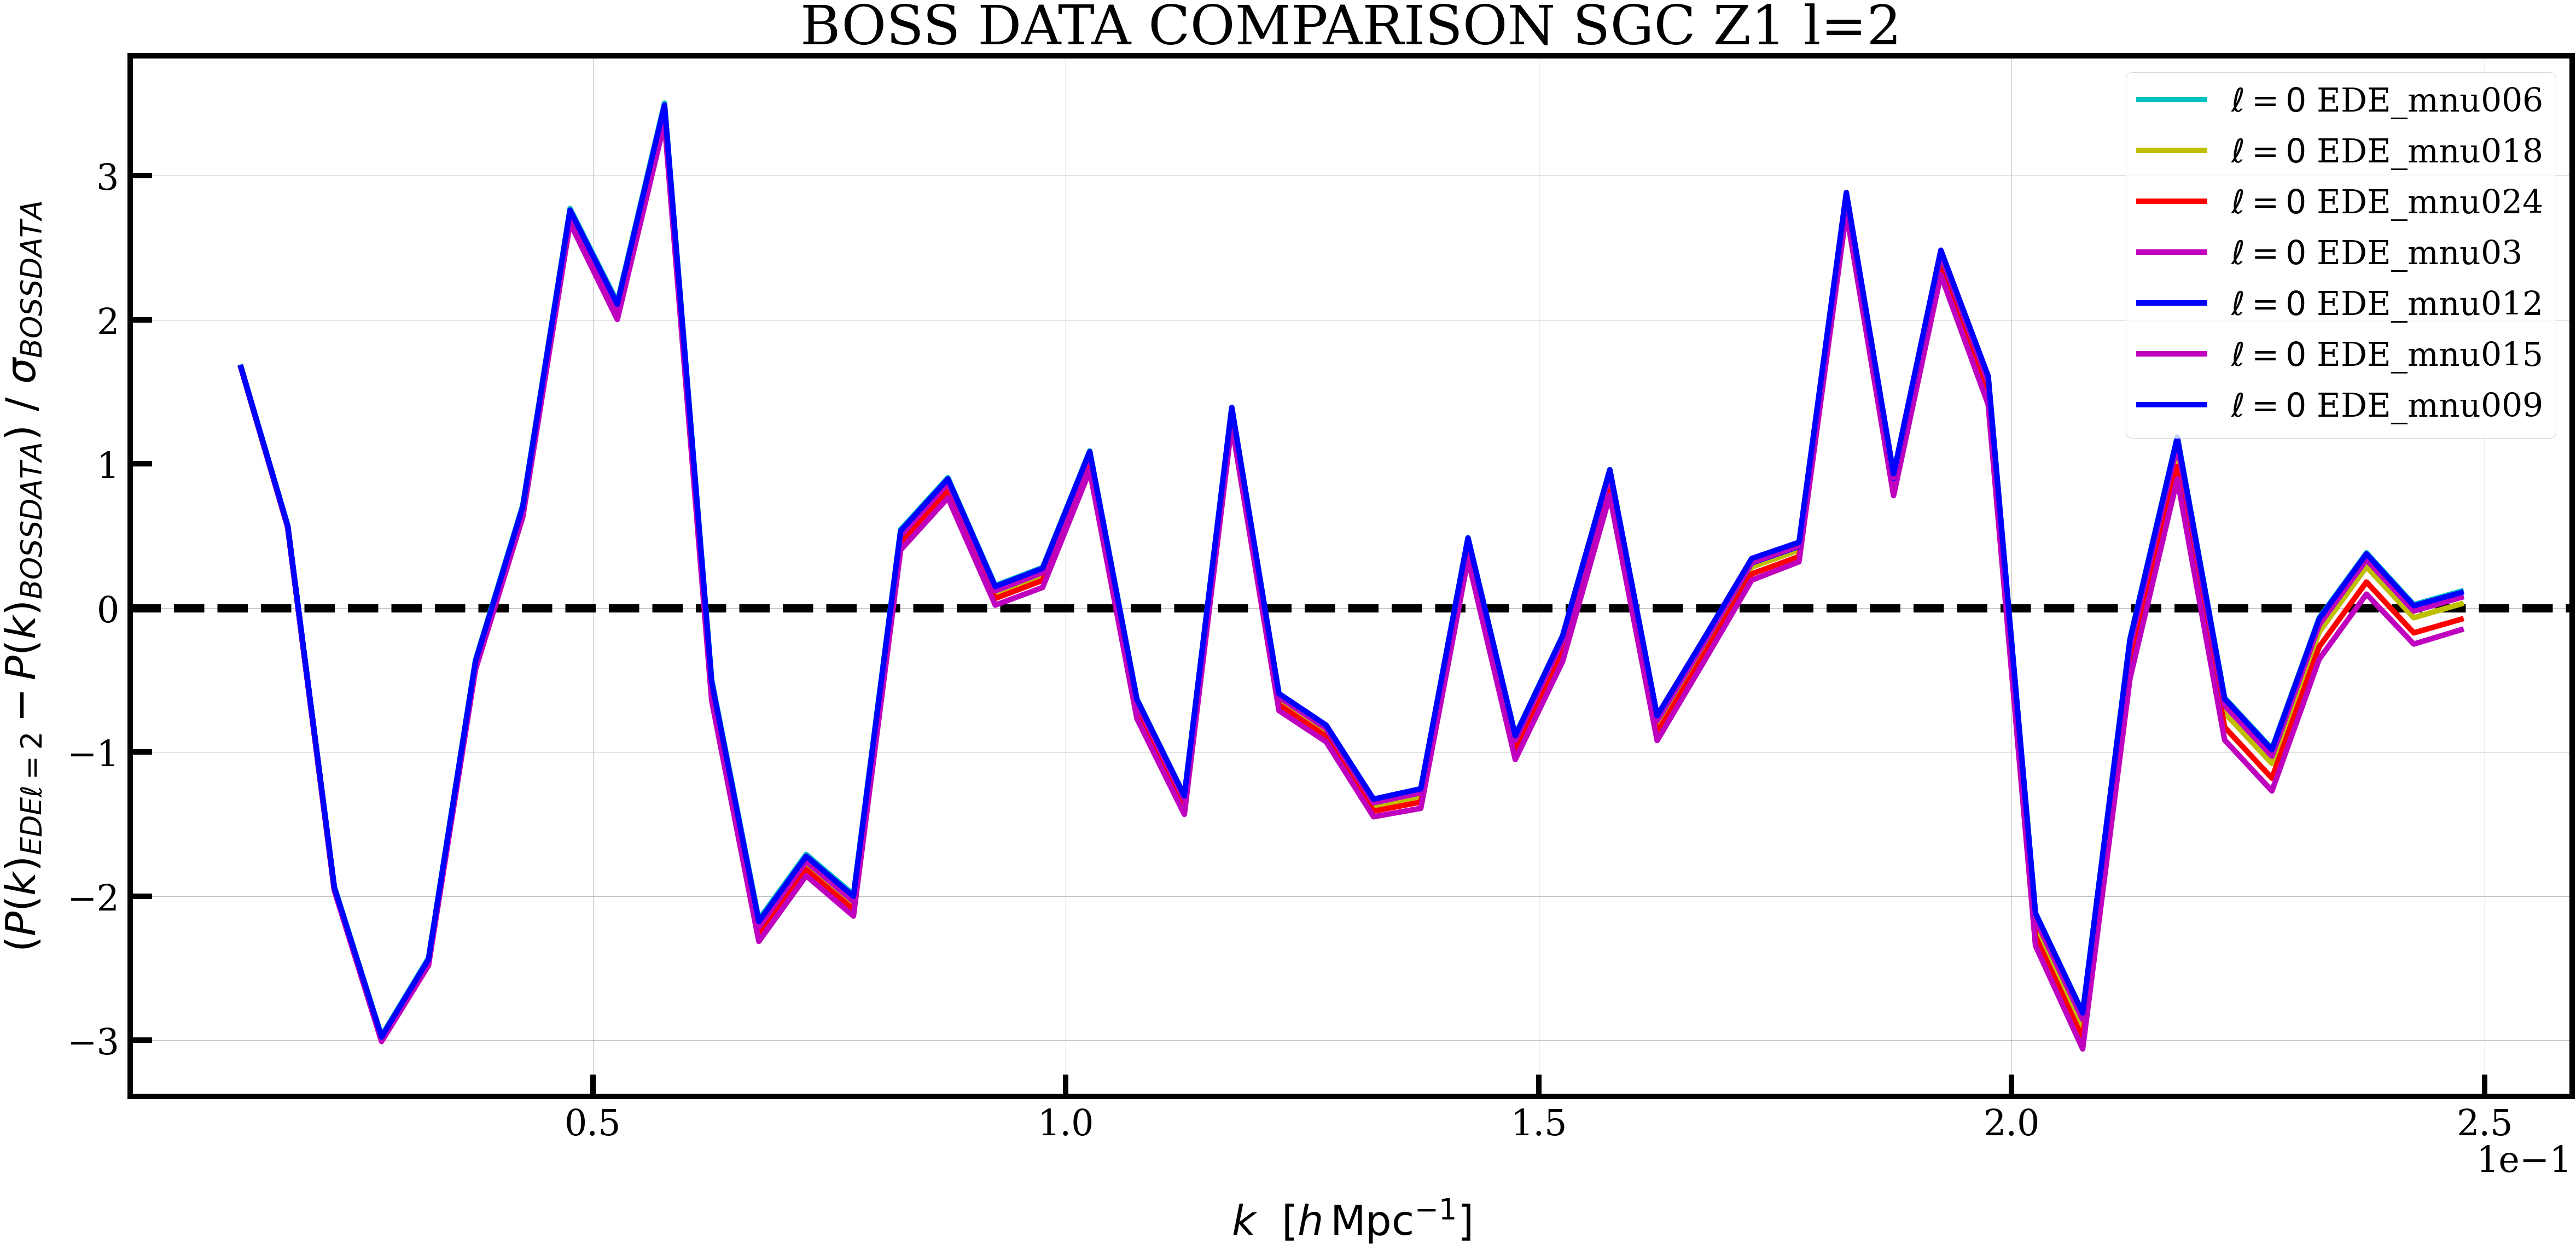

In [37]:
matplotlib.axis.YAxis.OFFSETTEXTPAD = 25
fig, ax3 = plt.subplots(figsize=(80,35))


ax3.grid()
ax3.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax3.axhline(0,c='k',lw=15,ls='--')

ax3.plot(kvalsz1,np.array(pk_g2_EDE_pp_ratioz1sc),color='c', lw = 10, label=r'$\ell = 0$ EDE_mnu006')
ax3.plot(kvalsz1,np.array(pk_g2_EDE_mnu018_ratioz1sc),color='y',lw = 10, label=r'$\ell = 0$ EDE_mnu018')
ax3.plot(kvalsz1,np.array(pk_g2_EDE_mnu024_ratioz1sc),color='r',lw = 10, label=r'$\ell = 0$ EDE_mnu024')
ax3.plot(kvalsz1,np.array(pk_g2_EDE_mnu03_ratioz1sc),color='m', lw = 10, label=r'$\ell = 0$ EDE_mnu03')
ax3.plot(kvalsz1,np.array(pk_g2_EDE_mnu012_ratioz1sc),color='b', lw = 10, label=r'$\ell = 0$ EDE_mnu012')
ax3.plot(kvalsz1,np.array(pk_g2_EDE_mnu015_ratioz1sc),color='m', lw = 10, label=r'$\ell = 0$ EDE_mnu015')
ax3.plot(kvalsz1,np.array(pk_g2_EDE_mnu009_ratioz1sc),color='b', lw = 10, label=r'$\ell = 0$ EDE_mnu009')

ax3.set_xlabel(r'$k$  $[h\, {\rm Mpc}^{-1}]$')
ax3.set_ylabel(r'$ \left( P(k)_{EDE \ell = 2} - P(k)_{BOSS DATA} \right) ~ \left/ ~ \sigma_{BOSS DATA} \right.$',labelpad=40)#,fontsize=25)
ax3.tick_params(pad=20)
ax3.tick_params(which='major',axis='x', length=40, width=10, direction='in')
ax3.tick_params(which='minor',axis='x', length=25, width=5, direction='in')
ax3.tick_params(which='major',axis='y', length=40, width=10, direction='in')
ax3.tick_params(which='minor',axis='y', length=25, width=5, direction='in')


ax3.set_title('BOSS DATA COMPARISON SGC Z1 l=2', fontsize=100)

ax3.legend(loc='best')

fig.savefig('multipoles_comparison_residuals_l=2.pdf',bbox_inches='tight')

## Consider the breakdown of the total sigma-weighted deviations

In [38]:
delta_pp = [np.sum(np.abs(pk_g0_EDE_pp_ratioz1)), np.sum(np.abs(pk_g0_EDE_pp_ratioz1sc)),np.sum(np.abs(pk_g2_EDE_pp_ratioz1)), np.sum(np.abs(pk_g2_EDE_pp_ratioz1sc)), \
np.sum(np.abs(pk_g0_EDE_pp_ratioz3)), np.sum(np.abs(pk_g0_EDE_pp_ratioz3sc)), np.sum(np.abs(pk_g2_EDE_pp_ratioz3)), np.sum(np.abs(pk_g2_EDE_pp_ratioz3sc))]

delta_mnu009 = [np.sum(np.abs(pk_g0_EDE_mnu009_ratioz1)), np.sum(np.abs(pk_g0_EDE_mnu009_ratioz1sc)),np.sum(np.abs(pk_g2_EDE_mnu009_ratioz1)), np.sum(np.abs(pk_g2_EDE_mnu009_ratioz1sc)), \
np.sum(np.abs(pk_g0_EDE_mnu009_ratioz3)), np.sum(np.abs(pk_g0_EDE_mnu009_ratioz3sc)), np.sum(np.abs(pk_g2_EDE_mnu009_ratioz3)), np.sum(np.abs(pk_g2_EDE_mnu009_ratioz3sc))]

delta_mnu012 = [np.sum(np.abs(pk_g0_EDE_mnu012_ratioz1)), np.sum(np.abs(pk_g0_EDE_mnu012_ratioz1sc)),np.sum(np.abs(pk_g2_EDE_mnu012_ratioz1)), np.sum(np.abs(pk_g2_EDE_mnu012_ratioz1sc)), \
np.sum(np.abs(pk_g0_EDE_mnu012_ratioz3)), np.sum(np.abs(pk_g0_EDE_mnu012_ratioz3sc)), np.sum(np.abs(pk_g2_EDE_mnu012_ratioz3)), np.sum(np.abs(pk_g2_EDE_mnu012_ratioz3sc))]

delta_mnu015 = [np.sum(np.abs(pk_g0_EDE_mnu015_ratioz1)), np.sum(np.abs(pk_g0_EDE_mnu015_ratioz1sc)),np.sum(np.abs(pk_g2_EDE_mnu015_ratioz1)), np.sum(np.abs(pk_g2_EDE_mnu015_ratioz1sc)), \
np.sum(np.abs(pk_g0_EDE_mnu015_ratioz3)), np.sum(np.abs(pk_g0_EDE_mnu015_ratioz3sc)), np.sum(np.abs(pk_g2_EDE_mnu015_ratioz3)), np.sum(np.abs(pk_g2_EDE_mnu015_ratioz3sc))]

delta_mnu018 = [np.sum(np.abs(pk_g0_EDE_mnu018_ratioz1)), np.sum(np.abs(pk_g0_EDE_mnu018_ratioz1sc)),np.sum(np.abs(pk_g2_EDE_mnu018_ratioz1)), np.sum(np.abs(pk_g2_EDE_mnu018_ratioz1sc)), \
np.sum(np.abs(pk_g0_EDE_mnu018_ratioz3)), np.sum(np.abs(pk_g0_EDE_mnu018_ratioz3sc)), np.sum(np.abs(pk_g2_EDE_mnu018_ratioz3)), np.sum(np.abs(pk_g2_EDE_mnu018_ratioz3sc))]

delta_mnu024 = [np.sum(np.abs(pk_g0_EDE_mnu024_ratioz1)), np.sum(np.abs(pk_g0_EDE_mnu024_ratioz1sc)),np.sum(np.abs(pk_g2_EDE_mnu024_ratioz1)), np.sum(np.abs(pk_g2_EDE_mnu024_ratioz1sc)), \
np.sum(np.abs(pk_g0_EDE_mnu024_ratioz3)), np.sum(np.abs(pk_g0_EDE_mnu024_ratioz3sc)), np.sum(np.abs(pk_g2_EDE_mnu024_ratioz3)), np.sum(np.abs(pk_g2_EDE_mnu024_ratioz3sc))]

delta_mnu03 = [np.sum(np.abs(pk_g0_EDE_mnu03_ratioz1)), np.sum(np.abs(pk_g0_EDE_mnu03_ratioz1sc)),np.sum(np.abs(pk_g2_EDE_mnu03_ratioz1)), np.sum(np.abs(pk_g2_EDE_mnu03_ratioz1sc)), \
np.sum(np.abs(pk_g0_EDE_mnu03_ratioz3)), np.sum(np.abs(pk_g0_EDE_mnu03_ratioz3sc)), np.sum(np.abs(pk_g2_EDE_mnu03_ratioz3)), np.sum(np.abs(pk_g2_EDE_mnu03_ratioz3sc))]


    

### Plot the breakdown of the sigma weighted difference to see where the chi2 contribution comes from

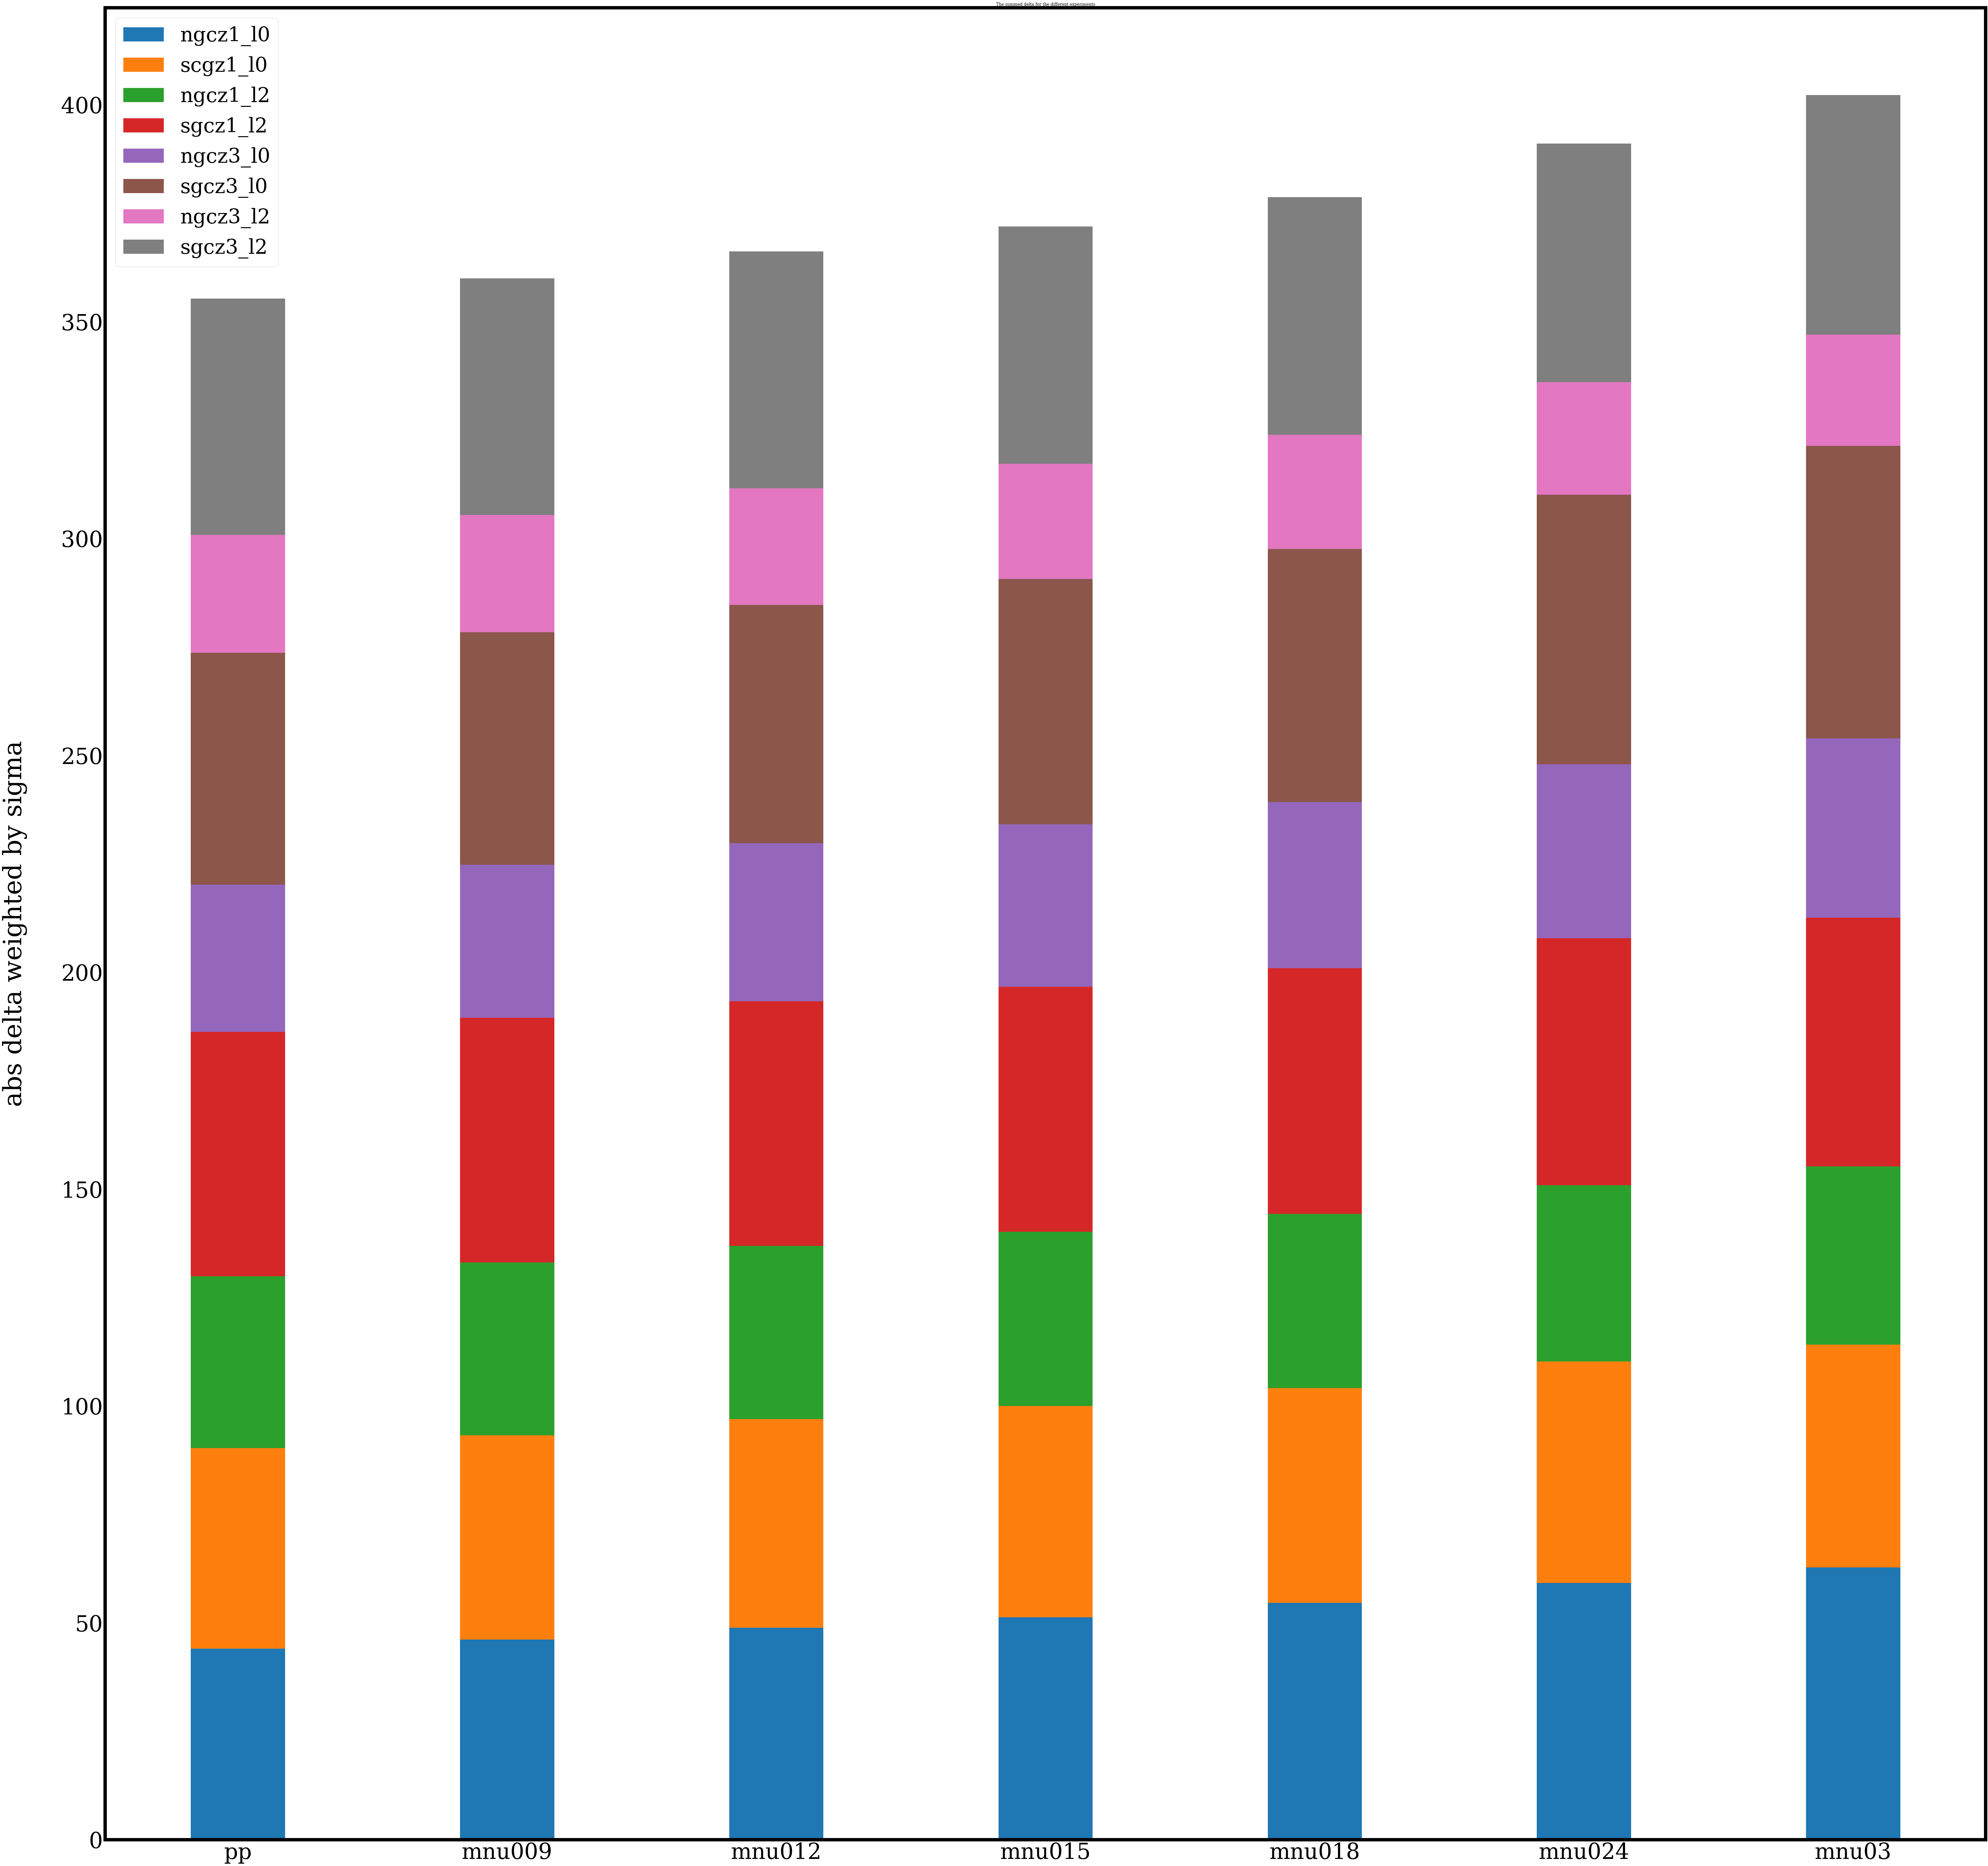

In [39]:
labels = ['pp', 'mnu009', 'mnu012', 'mnu015', 'mnu018', 'mnu024', 'mnu03']
ngcz1_l0 = np.array([delta_pp[0], delta_mnu009[0], delta_mnu012[0], delta_mnu015[0], delta_mnu018[0], delta_mnu024[0], delta_mnu03[0]])
scgz1_l0 = np.array([delta_pp[1], delta_mnu009[1], delta_mnu012[1], delta_mnu015[1], delta_mnu018[1], delta_mnu024[1], delta_mnu03[1]])
ngcz1_l2 = np.array([delta_pp[2], delta_mnu009[2], delta_mnu012[2], delta_mnu015[2], delta_mnu018[2], delta_mnu024[2], delta_mnu03[2]])
sgcz1_l2 = np.array([delta_pp[3], delta_mnu009[3], delta_mnu012[3], delta_mnu015[3], delta_mnu018[3], delta_mnu024[3], delta_mnu03[3]])
ngcz3_l0 = np.array([delta_pp[4], delta_mnu009[4], delta_mnu012[4], delta_mnu015[4], delta_mnu018[4], delta_mnu024[4], delta_mnu03[4]])
sgcz3_l0 = np.array([delta_pp[5], delta_mnu009[5], delta_mnu012[5], delta_mnu015[5], delta_mnu018[5], delta_mnu024[5], delta_mnu03[5]])
ngcz3_l2 = np.array([delta_pp[6], delta_mnu009[6], delta_mnu012[6], delta_mnu015[6], delta_mnu018[6], delta_mnu024[6], delta_mnu03[6]])
sgcz3_l2 = np.array([delta_pp[7], delta_mnu009[7], delta_mnu012[7], delta_mnu015[7], delta_mnu018[7], delta_mnu024[7], delta_mnu03[7]])


width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots(figsize=(100,100))

ax.bar(labels, ngcz1_l0, width, label='ngcz1_l0')
ax.bar(labels, scgz1_l0, width, bottom=ngcz1_l0,
       label='scgz1_l0')
ax.bar(labels, ngcz1_l2, width, bottom=ngcz1_l0+scgz1_l0,
       label='ngcz1_l2')
ax.bar(labels, sgcz1_l2, width, bottom=ngcz1_l0+scgz1_l0+ngcz1_l2,
       label='sgcz1_l2')
ax.bar(labels, ngcz3_l0, width, bottom=ngcz1_l0+scgz1_l0+ngcz1_l2+sgcz1_l2,
       label='ngcz3_l0')
ax.bar(labels, sgcz3_l0, width, bottom=ngcz1_l0+scgz1_l0+ngcz1_l2+sgcz1_l2+ngcz3_l0,
       label='sgcz3_l0')
ax.bar(labels, ngcz3_l2, width, bottom=ngcz1_l0+scgz1_l0+ngcz1_l2+sgcz1_l2+ngcz3_l0+sgcz3_l0,
       label='ngcz3_l2')
ax.bar(labels, sgcz3_l2, width, bottom=ngcz1_l0+scgz1_l0+ngcz1_l2+sgcz1_l2+ngcz3_l0+sgcz3_l0+ngcz3_l2,
       label='sgcz3_l2')

ax.set_ylabel(r'abs delta weighted by sigma')
ax.set_title('The summed delta for the different experiments')
ax.legend()

plt.show()

### Take-away

These residual plots show that the difference with repect to data comes mostly from a mis-match in BAO position and not to do with the amplitude of clustering (which is not correlated to the $\sigma_8$ bestfit model values - this shows the clustering amplitude can be re-absorbed by varaitions of the nuisance parameters